# インポート

In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt

#ベクトル化
from transformers import BertJapaneseTokenizer, BertModel
from sentence_transformers import SentenceTransformer
from sentence_transformers import models
import torch

#OneHotエンコーディング
from sklearn.preprocessing import OneHotEncoder

#多クラス分類
import lightgbm as lgb #LightGBM
from sklearn.model_selection import train_test_split # データセット分割用
from sklearn.metrics import accuracy_score # モデル評価用(正答率)
from sklearn.metrics import log_loss # モデル評価用(logloss)     
from sklearn.metrics import roc_auc_score # モデル評価用(auc)

# 翻訳
# -*- coding: utf-8
from googletrans import Translator
translator = Translator()

## googletransでエラーが出る場合

AttributeError: 'NoneType' object has no attribute 'group'  
このエラーが出る場合はバージョンが問題らしい  
一旦、アンインストールして

In [ ]:
!pip uninstall googletrans

バージョンを指定して入れなおす

In [ ]:
!pip install googletrans==3.1.0a0

# データセットの読み込み

In [3]:
df_org = pd.read_excel("../data/Stream.xlsx")

In [27]:
df = df_org.iloc[5:,1:3]
df.set_axis(["sentence","sentiment"], axis="columns", inplace=True)

In [32]:
df[df["judge"] == "ネガティブ"].count()

text     681
judge    681
dtype: int64

In [39]:
df_drop = df.drop_duplicates()
df_drop[df_drop["judge"] == "ニュートラル"].count()

text     3332
judge    3332
dtype: int64

# Wrimeデータセット

## データセットの確認

In [149]:
df_wrime = pd.read_table("../wrime/wrime-ver2.tsv")

In [150]:
df = df_wrime.loc[:,["Sentence","Avg. Readers_Sentiment"]]
df

,Sentence,Avg. Readers_Sentiment
0,ぼけっとしてたらこんな時間。チャリあるから食べにでたいのに…,-1
1,今日の月も白くて明るい。昨日より雲が少なくてキレイな〜 と立ち止まる帰り道。チャリなし生活も...,1
2,早寝するつもりが飲み物がなくなりコンビニへ。ん、今日、風が涼しいな。,0
3,眠い、眠れない。,-1
4,ただいま〜 って新体操してるやん!外食する気満々で家に何もないのに!テレビから離れられない…!,0
...,...,...
34995,真夜中にふと思い立ち、ノートPCを持って部屋を出て、ダイニングで仕事したらすんごい捗った。\...,1
34996,ぐっどこんでぃしょん。\n心も頭もクリア。\n秋分の日のおかげかな？\n人と自然としっとり過...,1
34997,朝から免許の更新へ。\n90分で終わり、出口へ向かうと献血の呼びかけが。\nみんな通り過ぎて...,1
34998,夜も更けて参りましたが、食後のコーヒーが飲みたいのでドリップ開始…\n\nぼんやり秋の夜長を...,1


## 前処理

### sentimentの置き換え

#### 置き換えの実行

In [151]:
dict_rep = {-2:-1, -1:-1, 0:0, 1:1, 2:1}
df.replace(dict_rep,inplace=True)
df.set_axis(["text","sentiment"], axis="columns", inplace=True)
df.head()

,text,sentiment
0,ぼけっとしてたらこんな時間。チャリあるから食べにでたいのに…,-1
1,今日の月も白くて明るい。昨日より雲が少なくてキレイな〜 と立ち止まる帰り道。チャリなし生活も...,1
2,早寝するつもりが飲み物がなくなりコンビニへ。ん、今日、風が涼しいな。,0
3,眠い、眠れない。,-1
4,ただいま〜 って新体操してるやん!外食する気満々で家に何もないのに!テレビから離れられない…!,0


#### 確認

In [152]:
neg = df[df["sentiment"]==-1].loc[:,"sentiment"].count()
neu = df[df["sentiment"]==0].loc[:,"sentiment"].count()
pos = df[df["sentiment"]==1].loc[:,"sentiment"].count()
print(f"negative:{neg}")
print(f"neutral:{neu}")
print(f"positive:{pos}")

negative:12155
neutral:11462
positive:11383


In [153]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35000 entries, 0 to 34999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       35000 non-null  object
 1   sentiment  35000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 547.0+ KB


In [154]:
for i, text in enumerate(df.iloc[:1000,0]):
    print(f"{i}:{text}")

0:ぼけっとしてたらこんな時間。チャリあるから食べにでたいのに…
1:今日の月も白くて明るい。昨日より雲が少なくてキレイな〜 と立ち止まる帰り道。チャリなし生活も悪くない。
2:早寝するつもりが飲み物がなくなりコンビニへ。ん、今日、風が涼しいな。
3:眠い、眠れない。
4:ただいま〜 って新体操してるやん!外食する気満々で家に何もないのに!テレビから離れられない…!
5:表情筋が衰えてきてる。まずいな…
6:やばい。おもろいな〜思ってみてみた「シャレードがいっぱい」。よすぎるやん。
7:おなかすいた…夜ご飯仲間募集。
8:よく寝た。暴走バスの夢見た。からだいたい。
9:最近アップにしていたので気づかなかったけど、ちゃんとブローしたらモテキ小宮山夏樹(後期)に似てきてる。この感じ定着したらパーマしよ。
10:月末ミーティング終了。いつものことだが自分のミーティング力のなさに凹む。もう走り出すしかない。バッティングセンターいこうぜ!
11:COWCOWヨシ君の顔色が最近ずっと悪い。病気ちゃうん?心配やわ。
12:シャンプーいきたい…
13:BIGBANGの人がえみちゃんねるにでてた。今、水泳の立石が…似すぎ。どちらも、生半可に喋りが達者でちょっとウザイ。でも立石なんかすき。
14:久々に自炊した。最近すごくやせたと評判なので、ごはんがすすむおかずをたんと。二膳半たべた。よしっ!
15:雨…（笑）
16:外反母趾が悪化。なぜ?ヒール止めてるし幅広い靴しか履いてないのに。本格的に治療すっかな。
17:待ち人は来ないのではないかという疑念がふとよぎる。涼しくなったなぁ。
18:昔夢を語った仲間と数年ぶりの再会!相変わらず、だったけど少し大人になっていた僕ら、だった。それぞれの道で頑張っててきっと色々あるけど、昔みたいに笑える時間が嬉しかった。昔見た未来まであと4年。がんばろ。
19:みんな幸せになったらいいなって、なんか普通にそう思う。日曜と月曜と火曜会った人たちありがとう。また明日からがんばろう。オヤスミナサイ
20:回鍋肉を作るつもりで何か違うやつになった。でもウマい!ウマすぎるぜ回鍋肉じゃないやつ!!
21:朝はパンケーキとサンドイッチ、昼はお弁当とサンドイッチ、夜は回鍋肉とごはんとパンケーキ。昨日焼いたチョコケーキがもう残り30度…好きなものを好きなときにたべるんだ!

#### 不要な要素を置き換え

In [155]:
df["text"] = df["text"]\
    .str.replace("\n"," ")\
    .str.replace("�","")\
    .str.replace("×","と")\
    .str.replace("&","と")\
    .str.replace("→"," ")

In [156]:
df.tail()

,text,sentiment
34995,真夜中にふと思い立ち、ノートPCを持って部屋を出て、ダイニングで仕事したらすんごい捗った。 ...,1
34996,ぐっどこんでぃしょん。 心も頭もクリア。 秋分の日のおかげかな？ 人と自然としっとり過ごした...,1
34997,朝から免許の更新へ。 90分で終わり、出口へ向かうと献血の呼びかけが。 みんな通り過ぎていく...,1
34998,夜も更けて参りましたが、食後のコーヒーが飲みたいのでドリップ開始… ぼんやり秋の夜長を楽し...,1
34999,コーヒー休憩（kahavitauko） いつもの豆なのにすごく美味しくできた レシピは...,1


# 文章のベクトル化
参考：  
https://techblog.gmo-ap.jp/2022/12/21/bert_calc_sentence_similarity/

## 準備

In [38]:
# !pip install torch
# !pip install transformers
# !pip install sentence_transformers
# !pip install fugashi
# !pip install ipadic

## インポート

In [56]:
from transformers import BertJapaneseTokenizer, BertModel
from sentence_transformers import SentenceTransformer
from sentence_transformers import models
import torch

## tokenizerとbertのインスタンス化

In [23]:
MODEL_NAME = 'cl-tohoku/bert-base-japanese-whole-word-masking'
tokenizer = BertJapaneseTokenizer.from_pretrained(MODEL_NAME)
model = BertModel.from_pretrained(MODEL_NAME)

Some weights of the model checkpoint at cl-tohoku/bert-base-japanese-whole-word-masking were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## 関数

In [24]:
def sentence_to_vector(model, tokenizer, sentence):
    # 文を単語に区切って数字にラベル化
    tokens = tokenizer(sentence)["input_ids"]#<meta charset="utf-8">
    
    # BERTモデルの処理のためtensor型に変換
    input = torch.tensor(tokens).reshape(1,-1)
    
    # BERTモデルに入力し文のベクトルを取得
    with torch.no_grad():
        outputs = model(input, output_hidden_states=True)
        last_hidden_state = outputs.last_hidden_state[0]#<meta charset="utf-8">
        averaged_hidden_state = last_hidden_state.sum(dim=0) / len(last_hidden_state)
    return averaged_hidden_state

### お試し

In [25]:
sentence = "我輩は猫である。"
sentence_vector = sentence_to_vector(model, tokenizer, sentence)
print(f"{sentence_vector.shape}\n{sentence_vector}")

torch.Size([768])
tensor([ 2.4454e-01,  2.9372e-01,  1.6882e-01,  1.1274e-01, -1.8055e-01,
         4.2808e-02,  1.0142e-01,  4.4268e-02,  5.0031e-02,  2.0824e-02,
         1.3566e-01, -7.1067e-03,  1.5957e-01, -3.5578e-02,  1.5130e-01,
        -2.6968e-01, -4.7743e-02,  4.4985e-01, -2.4804e-01, -1.4153e-01,
        -3.1910e-01, -1.0676e-01,  4.6794e-01, -1.5085e-01, -1.2440e-01,
         4.8003e-01, -1.0972e-01, -5.1514e-01,  8.3250e-02,  4.6792e-02,
        -1.8218e-01, -1.2965e-01, -6.1456e-01,  4.6631e-02,  5.1781e-02,
         1.2178e-01,  8.4007e-02, -1.4694e-01,  2.5117e-01, -3.7880e-01,
         8.2096e-02,  1.2070e-01, -3.0222e-01,  2.8130e-01,  3.2446e-01,
         3.1479e-01,  1.6098e-01,  2.6709e-01, -1.1303e-01,  1.1854e-01,
         1.8536e-01,  1.4211e-01,  1.6210e-01, -3.9973e-02, -1.0685e-01,
        -4.3471e-01, -3.8161e-01,  1.0611e-01, -3.3614e-03, -1.8463e-01,
         1.4684e-01, -6.4462e-02,  2.6719e-01, -6.0871e-01, -2.2559e-01,
        -8.5902e-01,  5.4881e-01,

## 変換の実行

In [32]:
vector = []
for i, temp in enumerate(df["text"]):
    print(f"{i+1}行目")
    temp_vectors = sentence_to_vector(model, tokenizer, temp)
    dict_temp = {}
    for j, temp_vector in enumerate(temp_vectors):
        name = f"vector_{j}"
        dict_temp[name] = temp_vector.numpy()
    vector.append(dict_temp)
    print(len(vector),len(vector[i]))
df_vector = pd.DataFrame(vector)

1行目
1 768
2行目
2 768
3行目
3 768
4行目
4 768
5行目
5 768
6行目
6 768
7行目
7 768
8行目
8 768
9行目
9 768
10行目
10 768
11行目
11 768
12行目
12 768
13行目
13 768
14行目
14 768
15行目
15 768
16行目
16 768
17行目
17 768
18行目
18 768
19行目
19 768
20行目
20 768
21行目
21 768
22行目
22 768
23行目
23 768
24行目
24 768
25行目
25 768
26行目
26 768
27行目
27 768
28行目
28 768
29行目
29 768
30行目
30 768
31行目
31 768
32行目
32 768
33行目
33 768
34行目
34 768
35行目
35 768
36行目
36 768
37行目
37 768
38行目
38 768
39行目
39 768
40行目
40 768
41行目
41 768
42行目
42 768
43行目
43 768
44行目
44 768
45行目
45 768
46行目
46 768
47行目
47 768
48行目
48 768
49行目
49 768
50行目
50 768
51行目
51 768
52行目
52 768
53行目
53 768
54行目
54 768
55行目
55 768
56行目
56 768
57行目
57 768
58行目
58 768
59行目
59 768
60行目
60 768
61行目
61 768
62行目
62 768
63行目
63 768
64行目
64 768
65行目
65 768
66行目
66 768
67行目
67 768
68行目
68 768
69行目
69 768
70行目
70 768
71行目
71 768
72行目
72 768
73行目
73 768
74行目
74 768
75行目
75 768
76行目
76 768
77行目
77 768
78行目
78 768
79行目
79 768
80行目
80 768
81行目
81 768
82行目
82 768
83行目
83 768
84行目
84 768
85行目
85 76

604 768
605行目
605 768
606行目
606 768
607行目
607 768
608行目
608 768
609行目
609 768
610行目
610 768
611行目
611 768
612行目
612 768
613行目
613 768
614行目
614 768
615行目
615 768
616行目
616 768
617行目
617 768
618行目
618 768
619行目
619 768
620行目
620 768
621行目
621 768
622行目
622 768
623行目
623 768
624行目
624 768
625行目
625 768
626行目
626 768
627行目
627 768
628行目
628 768
629行目
629 768
630行目
630 768
631行目
631 768
632行目
632 768
633行目
633 768
634行目
634 768
635行目
635 768
636行目
636 768
637行目
637 768
638行目
638 768
639行目
639 768
640行目
640 768
641行目
641 768
642行目
642 768
643行目
643 768
644行目
644 768
645行目
645 768
646行目
646 768
647行目
647 768
648行目
648 768
649行目
649 768
650行目
650 768
651行目
651 768
652行目
652 768
653行目
653 768
654行目
654 768
655行目
655 768
656行目
656 768
657行目
657 768
658行目
658 768
659行目
659 768
660行目
660 768
661行目
661 768
662行目
662 768
663行目
663 768
664行目
664 768
665行目
665 768
666行目
666 768
667行目
667 768
668行目
668 768
669行目
669 768
670行目
670 768
671行目
671 768
672行目
672 768
673行目
673 768
674行目
674 768
675行目
675 76

1167 768
1168行目
1168 768
1169行目
1169 768
1170行目
1170 768
1171行目
1171 768
1172行目
1172 768
1173行目
1173 768
1174行目
1174 768
1175行目
1175 768
1176行目
1176 768
1177行目
1177 768
1178行目
1178 768
1179行目
1179 768
1180行目
1180 768
1181行目
1181 768
1182行目
1182 768
1183行目
1183 768
1184行目
1184 768
1185行目
1185 768
1186行目
1186 768
1187行目
1187 768
1188行目
1188 768
1189行目
1189 768
1190行目
1190 768
1191行目
1191 768
1192行目
1192 768
1193行目
1193 768
1194行目
1194 768
1195行目
1195 768
1196行目
1196 768
1197行目
1197 768
1198行目
1198 768
1199行目
1199 768
1200行目
1200 768
1201行目
1201 768
1202行目
1202 768
1203行目
1203 768
1204行目
1204 768
1205行目
1205 768
1206行目
1206 768
1207行目
1207 768
1208行目
1208 768
1209行目
1209 768
1210行目
1210 768
1211行目
1211 768
1212行目
1212 768
1213行目
1213 768
1214行目
1214 768
1215行目
1215 768
1216行目
1216 768
1217行目
1217 768
1218行目
1218 768
1219行目
1219 768
1220行目
1220 768
1221行目
1221 768
1222行目
1222 768
1223行目
1223 768
1224行目
1224 768
1225行目
1225 768
1226行目
1226 768
1227行目
1227 768
1228行目
1228 768
1229行目
1229 768

1681 768
1682行目
1682 768
1683行目
1683 768
1684行目
1684 768
1685行目
1685 768
1686行目
1686 768
1687行目
1687 768
1688行目
1688 768
1689行目
1689 768
1690行目
1690 768
1691行目
1691 768
1692行目
1692 768
1693行目
1693 768
1694行目
1694 768
1695行目
1695 768
1696行目
1696 768
1697行目
1697 768
1698行目
1698 768
1699行目
1699 768
1700行目
1700 768
1701行目
1701 768
1702行目
1702 768
1703行目
1703 768
1704行目
1704 768
1705行目
1705 768
1706行目
1706 768
1707行目
1707 768
1708行目
1708 768
1709行目
1709 768
1710行目
1710 768
1711行目
1711 768
1712行目
1712 768
1713行目
1713 768
1714行目
1714 768
1715行目
1715 768
1716行目
1716 768
1717行目
1717 768
1718行目
1718 768
1719行目
1719 768
1720行目
1720 768
1721行目
1721 768
1722行目
1722 768
1723行目
1723 768
1724行目
1724 768
1725行目
1725 768
1726行目
1726 768
1727行目
1727 768
1728行目
1728 768
1729行目
1729 768
1730行目
1730 768
1731行目
1731 768
1732行目
1732 768
1733行目
1733 768
1734行目
1734 768
1735行目
1735 768
1736行目
1736 768
1737行目
1737 768
1738行目
1738 768
1739行目
1739 768
1740行目
1740 768
1741行目
1741 768
1742行目
1742 768
1743行目
1743 768

2196 768
2197行目
2197 768
2198行目
2198 768
2199行目
2199 768
2200行目
2200 768
2201行目
2201 768
2202行目
2202 768
2203行目
2203 768
2204行目
2204 768
2205行目
2205 768
2206行目
2206 768
2207行目
2207 768
2208行目
2208 768
2209行目
2209 768
2210行目
2210 768
2211行目
2211 768
2212行目
2212 768
2213行目
2213 768
2214行目
2214 768
2215行目
2215 768
2216行目
2216 768
2217行目
2217 768
2218行目
2218 768
2219行目
2219 768
2220行目
2220 768
2221行目
2221 768
2222行目
2222 768
2223行目
2223 768
2224行目
2224 768
2225行目
2225 768
2226行目
2226 768
2227行目
2227 768
2228行目
2228 768
2229行目
2229 768
2230行目
2230 768
2231行目
2231 768
2232行目
2232 768
2233行目
2233 768
2234行目
2234 768
2235行目
2235 768
2236行目
2236 768
2237行目
2237 768
2238行目
2238 768
2239行目
2239 768
2240行目
2240 768
2241行目
2241 768
2242行目
2242 768
2243行目
2243 768
2244行目
2244 768
2245行目
2245 768
2246行目
2246 768
2247行目
2247 768
2248行目
2248 768
2249行目
2249 768
2250行目
2250 768
2251行目
2251 768
2252行目
2252 768
2253行目
2253 768
2254行目
2254 768
2255行目
2255 768
2256行目
2256 768
2257行目
2257 768
2258行目
2258 768

2709 768
2710行目
2710 768
2711行目
2711 768
2712行目
2712 768
2713行目
2713 768
2714行目
2714 768
2715行目
2715 768
2716行目
2716 768
2717行目
2717 768
2718行目
2718 768
2719行目
2719 768
2720行目
2720 768
2721行目
2721 768
2722行目
2722 768
2723行目
2723 768
2724行目
2724 768
2725行目
2725 768
2726行目
2726 768
2727行目
2727 768
2728行目
2728 768
2729行目
2729 768
2730行目
2730 768
2731行目
2731 768
2732行目
2732 768
2733行目
2733 768
2734行目
2734 768
2735行目
2735 768
2736行目
2736 768
2737行目
2737 768
2738行目
2738 768
2739行目
2739 768
2740行目
2740 768
2741行目
2741 768
2742行目
2742 768
2743行目
2743 768
2744行目
2744 768
2745行目
2745 768
2746行目
2746 768
2747行目
2747 768
2748行目
2748 768
2749行目
2749 768
2750行目
2750 768
2751行目
2751 768
2752行目
2752 768
2753行目
2753 768
2754行目
2754 768
2755行目
2755 768
2756行目
2756 768
2757行目
2757 768
2758行目
2758 768
2759行目
2759 768
2760行目
2760 768
2761行目
2761 768
2762行目
2762 768
2763行目
2763 768
2764行目
2764 768
2765行目
2765 768
2766行目
2766 768
2767行目
2767 768
2768行目
2768 768
2769行目
2769 768
2770行目
2770 768
2771行目
2771 768

3223 768
3224行目
3224 768
3225行目
3225 768
3226行目
3226 768
3227行目
3227 768
3228行目
3228 768
3229行目
3229 768
3230行目
3230 768
3231行目
3231 768
3232行目
3232 768
3233行目
3233 768
3234行目
3234 768
3235行目
3235 768
3236行目
3236 768
3237行目
3237 768
3238行目
3238 768
3239行目
3239 768
3240行目
3240 768
3241行目
3241 768
3242行目
3242 768
3243行目
3243 768
3244行目
3244 768
3245行目
3245 768
3246行目
3246 768
3247行目
3247 768
3248行目
3248 768
3249行目
3249 768
3250行目
3250 768
3251行目
3251 768
3252行目
3252 768
3253行目
3253 768
3254行目
3254 768
3255行目
3255 768
3256行目
3256 768
3257行目
3257 768
3258行目
3258 768
3259行目
3259 768
3260行目
3260 768
3261行目
3261 768
3262行目
3262 768
3263行目
3263 768
3264行目
3264 768
3265行目
3265 768
3266行目
3266 768
3267行目
3267 768
3268行目
3268 768
3269行目
3269 768
3270行目
3270 768
3271行目
3271 768
3272行目
3272 768
3273行目
3273 768
3274行目
3274 768
3275行目
3275 768
3276行目
3276 768
3277行目
3277 768
3278行目
3278 768
3279行目
3279 768
3280行目
3280 768
3281行目
3281 768
3282行目
3282 768
3283行目
3283 768
3284行目
3284 768
3285行目
3285 768

3737 768
3738行目
3738 768
3739行目
3739 768
3740行目
3740 768
3741行目
3741 768
3742行目
3742 768
3743行目
3743 768
3744行目
3744 768
3745行目
3745 768
3746行目
3746 768
3747行目
3747 768
3748行目
3748 768
3749行目
3749 768
3750行目
3750 768
3751行目
3751 768
3752行目
3752 768
3753行目
3753 768
3754行目
3754 768
3755行目
3755 768
3756行目
3756 768
3757行目
3757 768
3758行目
3758 768
3759行目
3759 768
3760行目
3760 768
3761行目
3761 768
3762行目
3762 768
3763行目
3763 768
3764行目
3764 768
3765行目
3765 768
3766行目
3766 768
3767行目
3767 768
3768行目
3768 768
3769行目
3769 768
3770行目
3770 768
3771行目
3771 768
3772行目
3772 768
3773行目
3773 768
3774行目
3774 768
3775行目
3775 768
3776行目
3776 768
3777行目
3777 768
3778行目
3778 768
3779行目
3779 768
3780行目
3780 768
3781行目
3781 768
3782行目
3782 768
3783行目
3783 768
3784行目
3784 768
3785行目
3785 768
3786行目
3786 768
3787行目
3787 768
3788行目
3788 768
3789行目
3789 768
3790行目
3790 768
3791行目
3791 768
3792行目
3792 768
3793行目
3793 768
3794行目
3794 768
3795行目
3795 768
3796行目
3796 768
3797行目
3797 768
3798行目
3798 768
3799行目
3799 768

4250 768
4251行目
4251 768
4252行目
4252 768
4253行目
4253 768
4254行目
4254 768
4255行目
4255 768
4256行目
4256 768
4257行目
4257 768
4258行目
4258 768
4259行目
4259 768
4260行目
4260 768
4261行目
4261 768
4262行目
4262 768
4263行目
4263 768
4264行目
4264 768
4265行目
4265 768
4266行目
4266 768
4267行目
4267 768
4268行目
4268 768
4269行目
4269 768
4270行目
4270 768
4271行目
4271 768
4272行目
4272 768
4273行目
4273 768
4274行目
4274 768
4275行目
4275 768
4276行目
4276 768
4277行目
4277 768
4278行目
4278 768
4279行目
4279 768
4280行目
4280 768
4281行目
4281 768
4282行目
4282 768
4283行目
4283 768
4284行目
4284 768
4285行目
4285 768
4286行目
4286 768
4287行目
4287 768
4288行目
4288 768
4289行目
4289 768
4290行目
4290 768
4291行目
4291 768
4292行目
4292 768
4293行目
4293 768
4294行目
4294 768
4295行目
4295 768
4296行目
4296 768
4297行目
4297 768
4298行目
4298 768
4299行目
4299 768
4300行目
4300 768
4301行目
4301 768
4302行目
4302 768
4303行目
4303 768
4304行目
4304 768
4305行目
4305 768
4306行目
4306 768
4307行目
4307 768
4308行目
4308 768
4309行目
4309 768
4310行目
4310 768
4311行目
4311 768
4312行目
4312 768

4766 768
4767行目
4767 768
4768行目
4768 768
4769行目
4769 768
4770行目
4770 768
4771行目
4771 768
4772行目
4772 768
4773行目
4773 768
4774行目
4774 768
4775行目
4775 768
4776行目
4776 768
4777行目
4777 768
4778行目
4778 768
4779行目
4779 768
4780行目
4780 768
4781行目
4781 768
4782行目
4782 768
4783行目
4783 768
4784行目
4784 768
4785行目
4785 768
4786行目
4786 768
4787行目
4787 768
4788行目
4788 768
4789行目
4789 768
4790行目
4790 768
4791行目
4791 768
4792行目
4792 768
4793行目
4793 768
4794行目
4794 768
4795行目
4795 768
4796行目
4796 768
4797行目
4797 768
4798行目
4798 768
4799行目
4799 768
4800行目
4800 768
4801行目
4801 768
4802行目
4802 768
4803行目
4803 768
4804行目
4804 768
4805行目
4805 768
4806行目
4806 768
4807行目
4807 768
4808行目
4808 768
4809行目
4809 768
4810行目
4810 768
4811行目
4811 768
4812行目
4812 768
4813行目
4813 768
4814行目
4814 768
4815行目
4815 768
4816行目
4816 768
4817行目
4817 768
4818行目
4818 768
4819行目
4819 768
4820行目
4820 768
4821行目
4821 768
4822行目
4822 768
4823行目
4823 768
4824行目
4824 768
4825行目
4825 768
4826行目
4826 768
4827行目
4827 768
4828行目
4828 768

5279 768
5280行目
5280 768
5281行目
5281 768
5282行目
5282 768
5283行目
5283 768
5284行目
5284 768
5285行目
5285 768
5286行目
5286 768
5287行目
5287 768
5288行目
5288 768
5289行目
5289 768
5290行目
5290 768
5291行目
5291 768
5292行目
5292 768
5293行目
5293 768
5294行目
5294 768
5295行目
5295 768
5296行目
5296 768
5297行目
5297 768
5298行目
5298 768
5299行目
5299 768
5300行目
5300 768
5301行目
5301 768
5302行目
5302 768
5303行目
5303 768
5304行目
5304 768
5305行目
5305 768
5306行目
5306 768
5307行目
5307 768
5308行目
5308 768
5309行目
5309 768
5310行目
5310 768
5311行目
5311 768
5312行目
5312 768
5313行目
5313 768
5314行目
5314 768
5315行目
5315 768
5316行目
5316 768
5317行目
5317 768
5318行目
5318 768
5319行目
5319 768
5320行目
5320 768
5321行目
5321 768
5322行目
5322 768
5323行目
5323 768
5324行目
5324 768
5325行目
5325 768
5326行目
5326 768
5327行目
5327 768
5328行目
5328 768
5329行目
5329 768
5330行目
5330 768
5331行目
5331 768
5332行目
5332 768
5333行目
5333 768
5334行目
5334 768
5335行目
5335 768
5336行目
5336 768
5337行目
5337 768
5338行目
5338 768
5339行目
5339 768
5340行目
5340 768
5341行目
5341 768

5795 768
5796行目
5796 768
5797行目
5797 768
5798行目
5798 768
5799行目
5799 768
5800行目
5800 768
5801行目
5801 768
5802行目
5802 768
5803行目
5803 768
5804行目
5804 768
5805行目
5805 768
5806行目
5806 768
5807行目
5807 768
5808行目
5808 768
5809行目
5809 768
5810行目
5810 768
5811行目
5811 768
5812行目
5812 768
5813行目
5813 768
5814行目
5814 768
5815行目
5815 768
5816行目
5816 768
5817行目
5817 768
5818行目
5818 768
5819行目
5819 768
5820行目
5820 768
5821行目
5821 768
5822行目
5822 768
5823行目
5823 768
5824行目
5824 768
5825行目
5825 768
5826行目
5826 768
5827行目
5827 768
5828行目
5828 768
5829行目
5829 768
5830行目
5830 768
5831行目
5831 768
5832行目
5832 768
5833行目
5833 768
5834行目
5834 768
5835行目
5835 768
5836行目
5836 768
5837行目
5837 768
5838行目
5838 768
5839行目
5839 768
5840行目
5840 768
5841行目
5841 768
5842行目
5842 768
5843行目
5843 768
5844行目
5844 768
5845行目
5845 768
5846行目
5846 768
5847行目
5847 768
5848行目
5848 768
5849行目
5849 768
5850行目
5850 768
5851行目
5851 768
5852行目
5852 768
5853行目
5853 768
5854行目
5854 768
5855行目
5855 768
5856行目
5856 768
5857行目
5857 768

6309 768
6310行目
6310 768
6311行目
6311 768
6312行目
6312 768
6313行目
6313 768
6314行目
6314 768
6315行目
6315 768
6316行目
6316 768
6317行目
6317 768
6318行目
6318 768
6319行目
6319 768
6320行目
6320 768
6321行目
6321 768
6322行目
6322 768
6323行目
6323 768
6324行目
6324 768
6325行目
6325 768
6326行目
6326 768
6327行目
6327 768
6328行目
6328 768
6329行目
6329 768
6330行目
6330 768
6331行目
6331 768
6332行目
6332 768
6333行目
6333 768
6334行目
6334 768
6335行目
6335 768
6336行目
6336 768
6337行目
6337 768
6338行目
6338 768
6339行目
6339 768
6340行目
6340 768
6341行目
6341 768
6342行目
6342 768
6343行目
6343 768
6344行目
6344 768
6345行目
6345 768
6346行目
6346 768
6347行目
6347 768
6348行目
6348 768
6349行目
6349 768
6350行目
6350 768
6351行目
6351 768
6352行目
6352 768
6353行目
6353 768
6354行目
6354 768
6355行目
6355 768
6356行目
6356 768
6357行目
6357 768
6358行目
6358 768
6359行目
6359 768
6360行目
6360 768
6361行目
6361 768
6362行目
6362 768
6363行目
6363 768
6364行目
6364 768
6365行目
6365 768
6366行目
6366 768
6367行目
6367 768
6368行目
6368 768
6369行目
6369 768
6370行目
6370 768
6371行目
6371 768

6823 768
6824行目
6824 768
6825行目
6825 768
6826行目
6826 768
6827行目
6827 768
6828行目
6828 768
6829行目
6829 768
6830行目
6830 768
6831行目
6831 768
6832行目
6832 768
6833行目
6833 768
6834行目
6834 768
6835行目
6835 768
6836行目
6836 768
6837行目
6837 768
6838行目
6838 768
6839行目
6839 768
6840行目
6840 768
6841行目
6841 768
6842行目
6842 768
6843行目
6843 768
6844行目
6844 768
6845行目
6845 768
6846行目
6846 768
6847行目
6847 768
6848行目
6848 768
6849行目
6849 768
6850行目
6850 768
6851行目
6851 768
6852行目
6852 768
6853行目
6853 768
6854行目
6854 768
6855行目
6855 768
6856行目
6856 768
6857行目
6857 768
6858行目
6858 768
6859行目
6859 768
6860行目
6860 768
6861行目
6861 768
6862行目
6862 768
6863行目
6863 768
6864行目
6864 768
6865行目
6865 768
6866行目
6866 768
6867行目
6867 768
6868行目
6868 768
6869行目
6869 768
6870行目
6870 768
6871行目
6871 768
6872行目
6872 768
6873行目
6873 768
6874行目
6874 768
6875行目
6875 768
6876行目
6876 768
6877行目
6877 768
6878行目
6878 768
6879行目
6879 768
6880行目
6880 768
6881行目
6881 768
6882行目
6882 768
6883行目
6883 768
6884行目
6884 768
6885行目
6885 768

7338 768
7339行目
7339 768
7340行目
7340 768
7341行目
7341 768
7342行目
7342 768
7343行目
7343 768
7344行目
7344 768
7345行目
7345 768
7346行目
7346 768
7347行目
7347 768
7348行目
7348 768
7349行目
7349 768
7350行目
7350 768
7351行目
7351 768
7352行目
7352 768
7353行目
7353 768
7354行目
7354 768
7355行目
7355 768
7356行目
7356 768
7357行目
7357 768
7358行目
7358 768
7359行目
7359 768
7360行目
7360 768
7361行目
7361 768
7362行目
7362 768
7363行目
7363 768
7364行目
7364 768
7365行目
7365 768
7366行目
7366 768
7367行目
7367 768
7368行目
7368 768
7369行目
7369 768
7370行目
7370 768
7371行目
7371 768
7372行目
7372 768
7373行目
7373 768
7374行目
7374 768
7375行目
7375 768
7376行目
7376 768
7377行目
7377 768
7378行目
7378 768
7379行目
7379 768
7380行目
7380 768
7381行目
7381 768
7382行目
7382 768
7383行目
7383 768
7384行目
7384 768
7385行目
7385 768
7386行目
7386 768
7387行目
7387 768
7388行目
7388 768
7389行目
7389 768
7390行目
7390 768
7391行目
7391 768
7392行目
7392 768
7393行目
7393 768
7394行目
7394 768
7395行目
7395 768
7396行目
7396 768
7397行目
7397 768
7398行目
7398 768
7399行目
7399 768
7400行目
7400 768

7853 768
7854行目
7854 768
7855行目
7855 768
7856行目
7856 768
7857行目
7857 768
7858行目
7858 768
7859行目
7859 768
7860行目
7860 768
7861行目
7861 768
7862行目
7862 768
7863行目
7863 768
7864行目
7864 768
7865行目
7865 768
7866行目
7866 768
7867行目
7867 768
7868行目
7868 768
7869行目
7869 768
7870行目
7870 768
7871行目
7871 768
7872行目
7872 768
7873行目
7873 768
7874行目
7874 768
7875行目
7875 768
7876行目
7876 768
7877行目
7877 768
7878行目
7878 768
7879行目
7879 768
7880行目
7880 768
7881行目
7881 768
7882行目
7882 768
7883行目
7883 768
7884行目
7884 768
7885行目
7885 768
7886行目
7886 768
7887行目
7887 768
7888行目
7888 768
7889行目
7889 768
7890行目
7890 768
7891行目
7891 768
7892行目
7892 768
7893行目
7893 768
7894行目
7894 768
7895行目
7895 768
7896行目
7896 768
7897行目
7897 768
7898行目
7898 768
7899行目
7899 768
7900行目
7900 768
7901行目
7901 768
7902行目
7902 768
7903行目
7903 768
7904行目
7904 768
7905行目
7905 768
7906行目
7906 768
7907行目
7907 768
7908行目
7908 768
7909行目
7909 768
7910行目
7910 768
7911行目
7911 768
7912行目
7912 768
7913行目
7913 768
7914行目
7914 768
7915行目
7915 768

8367 768
8368行目
8368 768
8369行目
8369 768
8370行目
8370 768
8371行目
8371 768
8372行目
8372 768
8373行目
8373 768
8374行目
8374 768
8375行目
8375 768
8376行目
8376 768
8377行目
8377 768
8378行目
8378 768
8379行目
8379 768
8380行目
8380 768
8381行目
8381 768
8382行目
8382 768
8383行目
8383 768
8384行目
8384 768
8385行目
8385 768
8386行目
8386 768
8387行目
8387 768
8388行目
8388 768
8389行目
8389 768
8390行目
8390 768
8391行目
8391 768
8392行目
8392 768
8393行目
8393 768
8394行目
8394 768
8395行目
8395 768
8396行目
8396 768
8397行目
8397 768
8398行目
8398 768
8399行目
8399 768
8400行目
8400 768
8401行目
8401 768
8402行目
8402 768
8403行目
8403 768
8404行目
8404 768
8405行目
8405 768
8406行目
8406 768
8407行目
8407 768
8408行目
8408 768
8409行目
8409 768
8410行目
8410 768
8411行目
8411 768
8412行目
8412 768
8413行目
8413 768
8414行目
8414 768
8415行目
8415 768
8416行目
8416 768
8417行目
8417 768
8418行目
8418 768
8419行目
8419 768
8420行目
8420 768
8421行目
8421 768
8422行目
8422 768
8423行目
8423 768
8424行目
8424 768
8425行目
8425 768
8426行目
8426 768
8427行目
8427 768
8428行目
8428 768
8429行目
8429 768

8881 768
8882行目
8882 768
8883行目
8883 768
8884行目
8884 768
8885行目
8885 768
8886行目
8886 768
8887行目
8887 768
8888行目
8888 768
8889行目
8889 768
8890行目
8890 768
8891行目
8891 768
8892行目
8892 768
8893行目
8893 768
8894行目
8894 768
8895行目
8895 768
8896行目
8896 768
8897行目
8897 768
8898行目
8898 768
8899行目
8899 768
8900行目
8900 768
8901行目
8901 768
8902行目
8902 768
8903行目
8903 768
8904行目
8904 768
8905行目
8905 768
8906行目
8906 768
8907行目
8907 768
8908行目
8908 768
8909行目
8909 768
8910行目
8910 768
8911行目
8911 768
8912行目
8912 768
8913行目
8913 768
8914行目
8914 768
8915行目
8915 768
8916行目
8916 768
8917行目
8917 768
8918行目
8918 768
8919行目
8919 768
8920行目
8920 768
8921行目
8921 768
8922行目
8922 768
8923行目
8923 768
8924行目
8924 768
8925行目
8925 768
8926行目
8926 768
8927行目
8927 768
8928行目
8928 768
8929行目
8929 768
8930行目
8930 768
8931行目
8931 768
8932行目
8932 768
8933行目
8933 768
8934行目
8934 768
8935行目
8935 768
8936行目
8936 768
8937行目
8937 768
8938行目
8938 768
8939行目
8939 768
8940行目
8940 768
8941行目
8941 768
8942行目
8942 768
8943行目
8943 768

9394 768
9395行目
9395 768
9396行目
9396 768
9397行目
9397 768
9398行目
9398 768
9399行目
9399 768
9400行目
9400 768
9401行目
9401 768
9402行目
9402 768
9403行目
9403 768
9404行目
9404 768
9405行目
9405 768
9406行目
9406 768
9407行目
9407 768
9408行目
9408 768
9409行目
9409 768
9410行目
9410 768
9411行目
9411 768
9412行目
9412 768
9413行目
9413 768
9414行目
9414 768
9415行目
9415 768
9416行目
9416 768
9417行目
9417 768
9418行目
9418 768
9419行目
9419 768
9420行目
9420 768
9421行目
9421 768
9422行目
9422 768
9423行目
9423 768
9424行目
9424 768
9425行目
9425 768
9426行目
9426 768
9427行目
9427 768
9428行目
9428 768
9429行目
9429 768
9430行目
9430 768
9431行目
9431 768
9432行目
9432 768
9433行目
9433 768
9434行目
9434 768
9435行目
9435 768
9436行目
9436 768
9437行目
9437 768
9438行目
9438 768
9439行目
9439 768
9440行目
9440 768
9441行目
9441 768
9442行目
9442 768
9443行目
9443 768
9444行目
9444 768
9445行目
9445 768
9446行目
9446 768
9447行目
9447 768
9448行目
9448 768
9449行目
9449 768
9450行目
9450 768
9451行目
9451 768
9452行目
9452 768
9453行目
9453 768
9454行目
9454 768
9455行目
9455 768
9456行目
9456 768

9909 768
9910行目
9910 768
9911行目
9911 768
9912行目
9912 768
9913行目
9913 768
9914行目
9914 768
9915行目
9915 768
9916行目
9916 768
9917行目
9917 768
9918行目
9918 768
9919行目
9919 768
9920行目
9920 768
9921行目
9921 768
9922行目
9922 768
9923行目
9923 768
9924行目
9924 768
9925行目
9925 768
9926行目
9926 768
9927行目
9927 768
9928行目
9928 768
9929行目
9929 768
9930行目
9930 768
9931行目
9931 768
9932行目
9932 768
9933行目
9933 768
9934行目
9934 768
9935行目
9935 768
9936行目
9936 768
9937行目
9937 768
9938行目
9938 768
9939行目
9939 768
9940行目
9940 768
9941行目
9941 768
9942行目
9942 768
9943行目
9943 768
9944行目
9944 768
9945行目
9945 768
9946行目
9946 768
9947行目
9947 768
9948行目
9948 768
9949行目
9949 768
9950行目
9950 768
9951行目
9951 768
9952行目
9952 768
9953行目
9953 768
9954行目
9954 768
9955行目
9955 768
9956行目
9956 768
9957行目
9957 768
9958行目
9958 768
9959行目
9959 768
9960行目
9960 768
9961行目
9961 768
9962行目
9962 768
9963行目
9963 768
9964行目
9964 768
9965行目
9965 768
9966行目
9966 768
9967行目
9967 768
9968行目
9968 768
9969行目
9969 768
9970行目
9970 768
9971行目
9971 768

10378 768
10379行目
10379 768
10380行目
10380 768
10381行目
10381 768
10382行目
10382 768
10383行目
10383 768
10384行目
10384 768
10385行目
10385 768
10386行目
10386 768
10387行目
10387 768
10388行目
10388 768
10389行目
10389 768
10390行目
10390 768
10391行目
10391 768
10392行目
10392 768
10393行目
10393 768
10394行目
10394 768
10395行目
10395 768
10396行目
10396 768
10397行目
10397 768
10398行目
10398 768
10399行目
10399 768
10400行目
10400 768
10401行目
10401 768
10402行目
10402 768
10403行目
10403 768
10404行目
10404 768
10405行目
10405 768
10406行目
10406 768
10407行目
10407 768
10408行目
10408 768
10409行目
10409 768
10410行目
10410 768
10411行目
10411 768
10412行目
10412 768
10413行目
10413 768
10414行目
10414 768
10415行目
10415 768
10416行目
10416 768
10417行目
10417 768
10418行目
10418 768
10419行目
10419 768
10420行目
10420 768
10421行目
10421 768
10422行目
10422 768
10423行目
10423 768
10424行目
10424 768
10425行目
10425 768
10426行目
10426 768
10427行目
10427 768
10428行目
10428 768
10429行目
10429 768
10430行目
10430 768
10431行目
10431 768
10432行目
10432 768
10433行目
10433 768


10834 768
10835行目
10835 768
10836行目
10836 768
10837行目
10837 768
10838行目
10838 768
10839行目
10839 768
10840行目
10840 768
10841行目
10841 768
10842行目
10842 768
10843行目
10843 768
10844行目
10844 768
10845行目
10845 768
10846行目
10846 768
10847行目
10847 768
10848行目
10848 768
10849行目
10849 768
10850行目
10850 768
10851行目
10851 768
10852行目
10852 768
10853行目
10853 768
10854行目
10854 768
10855行目
10855 768
10856行目
10856 768
10857行目
10857 768
10858行目
10858 768
10859行目
10859 768
10860行目
10860 768
10861行目
10861 768
10862行目
10862 768
10863行目
10863 768
10864行目
10864 768
10865行目
10865 768
10866行目
10866 768
10867行目
10867 768
10868行目
10868 768
10869行目
10869 768
10870行目
10870 768
10871行目
10871 768
10872行目
10872 768
10873行目
10873 768
10874行目
10874 768
10875行目
10875 768
10876行目
10876 768
10877行目
10877 768
10878行目
10878 768
10879行目
10879 768
10880行目
10880 768
10881行目
10881 768
10882行目
10882 768
10883行目
10883 768
10884行目
10884 768
10885行目
10885 768
10886行目
10886 768
10887行目
10887 768
10888行目
10888 768
10889行目
10889 768


11291 768
11292行目
11292 768
11293行目
11293 768
11294行目
11294 768
11295行目
11295 768
11296行目
11296 768
11297行目
11297 768
11298行目
11298 768
11299行目
11299 768
11300行目
11300 768
11301行目
11301 768
11302行目
11302 768
11303行目
11303 768
11304行目
11304 768
11305行目
11305 768
11306行目
11306 768
11307行目
11307 768
11308行目
11308 768
11309行目
11309 768
11310行目
11310 768
11311行目
11311 768
11312行目
11312 768
11313行目
11313 768
11314行目
11314 768
11315行目
11315 768
11316行目
11316 768
11317行目
11317 768
11318行目
11318 768
11319行目
11319 768
11320行目
11320 768
11321行目
11321 768
11322行目
11322 768
11323行目
11323 768
11324行目
11324 768
11325行目
11325 768
11326行目
11326 768
11327行目
11327 768
11328行目
11328 768
11329行目
11329 768
11330行目
11330 768
11331行目
11331 768
11332行目
11332 768
11333行目
11333 768
11334行目
11334 768
11335行目
11335 768
11336行目
11336 768
11337行目
11337 768
11338行目
11338 768
11339行目
11339 768
11340行目
11340 768
11341行目
11341 768
11342行目
11342 768
11343行目
11343 768
11344行目
11344 768
11345行目
11345 768
11346行目
11346 768


11747 768
11748行目
11748 768
11749行目
11749 768
11750行目
11750 768
11751行目
11751 768
11752行目
11752 768
11753行目
11753 768
11754行目
11754 768
11755行目
11755 768
11756行目
11756 768
11757行目
11757 768
11758行目
11758 768
11759行目
11759 768
11760行目
11760 768
11761行目
11761 768
11762行目
11762 768
11763行目
11763 768
11764行目
11764 768
11765行目
11765 768
11766行目
11766 768
11767行目
11767 768
11768行目
11768 768
11769行目
11769 768
11770行目
11770 768
11771行目
11771 768
11772行目
11772 768
11773行目
11773 768
11774行目
11774 768
11775行目
11775 768
11776行目
11776 768
11777行目
11777 768
11778行目
11778 768
11779行目
11779 768
11780行目
11780 768
11781行目
11781 768
11782行目
11782 768
11783行目
11783 768
11784行目
11784 768
11785行目
11785 768
11786行目
11786 768
11787行目
11787 768
11788行目
11788 768
11789行目
11789 768
11790行目
11790 768
11791行目
11791 768
11792行目
11792 768
11793行目
11793 768
11794行目
11794 768
11795行目
11795 768
11796行目
11796 768
11797行目
11797 768
11798行目
11798 768
11799行目
11799 768
11800行目
11800 768
11801行目
11801 768
11802行目
11802 768


12206 768
12207行目
12207 768
12208行目
12208 768
12209行目
12209 768
12210行目
12210 768
12211行目
12211 768
12212行目
12212 768
12213行目
12213 768
12214行目
12214 768
12215行目
12215 768
12216行目
12216 768
12217行目
12217 768
12218行目
12218 768
12219行目
12219 768
12220行目
12220 768
12221行目
12221 768
12222行目
12222 768
12223行目
12223 768
12224行目
12224 768
12225行目
12225 768
12226行目
12226 768
12227行目
12227 768
12228行目
12228 768
12229行目
12229 768
12230行目
12230 768
12231行目
12231 768
12232行目
12232 768
12233行目
12233 768
12234行目
12234 768
12235行目
12235 768
12236行目
12236 768
12237行目
12237 768
12238行目
12238 768
12239行目
12239 768
12240行目
12240 768
12241行目
12241 768
12242行目
12242 768
12243行目
12243 768
12244行目
12244 768
12245行目
12245 768
12246行目
12246 768
12247行目
12247 768
12248行目
12248 768
12249行目
12249 768
12250行目
12250 768
12251行目
12251 768
12252行目
12252 768
12253行目
12253 768
12254行目
12254 768
12255行目
12255 768
12256行目
12256 768
12257行目
12257 768
12258行目
12258 768
12259行目
12259 768
12260行目
12260 768
12261行目
12261 768


12665 768
12666行目
12666 768
12667行目
12667 768
12668行目
12668 768
12669行目
12669 768
12670行目
12670 768
12671行目
12671 768
12672行目
12672 768
12673行目
12673 768
12674行目
12674 768
12675行目
12675 768
12676行目
12676 768
12677行目
12677 768
12678行目
12678 768
12679行目
12679 768
12680行目
12680 768
12681行目
12681 768
12682行目
12682 768
12683行目
12683 768
12684行目
12684 768
12685行目
12685 768
12686行目
12686 768
12687行目
12687 768
12688行目
12688 768
12689行目
12689 768
12690行目
12690 768
12691行目
12691 768
12692行目
12692 768
12693行目
12693 768
12694行目
12694 768
12695行目
12695 768
12696行目
12696 768
12697行目
12697 768
12698行目
12698 768
12699行目
12699 768
12700行目
12700 768
12701行目
12701 768
12702行目
12702 768
12703行目
12703 768
12704行目
12704 768
12705行目
12705 768
12706行目
12706 768
12707行目
12707 768
12708行目
12708 768
12709行目
12709 768
12710行目
12710 768
12711行目
12711 768
12712行目
12712 768
12713行目
12713 768
12714行目
12714 768
12715行目
12715 768
12716行目
12716 768
12717行目
12717 768
12718行目
12718 768
12719行目
12719 768
12720行目
12720 768


13121 768
13122行目
13122 768
13123行目
13123 768
13124行目
13124 768
13125行目
13125 768
13126行目
13126 768
13127行目
13127 768
13128行目
13128 768
13129行目
13129 768
13130行目
13130 768
13131行目
13131 768
13132行目
13132 768
13133行目
13133 768
13134行目
13134 768
13135行目
13135 768
13136行目
13136 768
13137行目
13137 768
13138行目
13138 768
13139行目
13139 768
13140行目
13140 768
13141行目
13141 768
13142行目
13142 768
13143行目
13143 768
13144行目
13144 768
13145行目
13145 768
13146行目
13146 768
13147行目
13147 768
13148行目
13148 768
13149行目
13149 768
13150行目
13150 768
13151行目
13151 768
13152行目
13152 768
13153行目
13153 768
13154行目
13154 768
13155行目
13155 768
13156行目
13156 768
13157行目
13157 768
13158行目
13158 768
13159行目
13159 768
13160行目
13160 768
13161行目
13161 768
13162行目
13162 768
13163行目
13163 768
13164行目
13164 768
13165行目
13165 768
13166行目
13166 768
13167行目
13167 768
13168行目
13168 768
13169行目
13169 768
13170行目
13170 768
13171行目
13171 768
13172行目
13172 768
13173行目
13173 768
13174行目
13174 768
13175行目
13175 768
13176行目
13176 768


13578 768
13579行目
13579 768
13580行目
13580 768
13581行目
13581 768
13582行目
13582 768
13583行目
13583 768
13584行目
13584 768
13585行目
13585 768
13586行目
13586 768
13587行目
13587 768
13588行目
13588 768
13589行目
13589 768
13590行目
13590 768
13591行目
13591 768
13592行目
13592 768
13593行目
13593 768
13594行目
13594 768
13595行目
13595 768
13596行目
13596 768
13597行目
13597 768
13598行目
13598 768
13599行目
13599 768
13600行目
13600 768
13601行目
13601 768
13602行目
13602 768
13603行目
13603 768
13604行目
13604 768
13605行目
13605 768
13606行目
13606 768
13607行目
13607 768
13608行目
13608 768
13609行目
13609 768
13610行目
13610 768
13611行目
13611 768
13612行目
13612 768
13613行目
13613 768
13614行目
13614 768
13615行目
13615 768
13616行目
13616 768
13617行目
13617 768
13618行目
13618 768
13619行目
13619 768
13620行目
13620 768
13621行目
13621 768
13622行目
13622 768
13623行目
13623 768
13624行目
13624 768
13625行目
13625 768
13626行目
13626 768
13627行目
13627 768
13628行目
13628 768
13629行目
13629 768
13630行目
13630 768
13631行目
13631 768
13632行目
13632 768
13633行目
13633 768


14034 768
14035行目
14035 768
14036行目
14036 768
14037行目
14037 768
14038行目
14038 768
14039行目
14039 768
14040行目
14040 768
14041行目
14041 768
14042行目
14042 768
14043行目
14043 768
14044行目
14044 768
14045行目
14045 768
14046行目
14046 768
14047行目
14047 768
14048行目
14048 768
14049行目
14049 768
14050行目
14050 768
14051行目
14051 768
14052行目
14052 768
14053行目
14053 768
14054行目
14054 768
14055行目
14055 768
14056行目
14056 768
14057行目
14057 768
14058行目
14058 768
14059行目
14059 768
14060行目
14060 768
14061行目
14061 768
14062行目
14062 768
14063行目
14063 768
14064行目
14064 768
14065行目
14065 768
14066行目
14066 768
14067行目
14067 768
14068行目
14068 768
14069行目
14069 768
14070行目
14070 768
14071行目
14071 768
14072行目
14072 768
14073行目
14073 768
14074行目
14074 768
14075行目
14075 768
14076行目
14076 768
14077行目
14077 768
14078行目
14078 768
14079行目
14079 768
14080行目
14080 768
14081行目
14081 768
14082行目
14082 768
14083行目
14083 768
14084行目
14084 768
14085行目
14085 768
14086行目
14086 768
14087行目
14087 768
14088行目
14088 768
14089行目
14089 768


14491 768
14492行目
14492 768
14493行目
14493 768
14494行目
14494 768
14495行目
14495 768
14496行目
14496 768
14497行目
14497 768
14498行目
14498 768
14499行目
14499 768
14500行目
14500 768
14501行目
14501 768
14502行目
14502 768
14503行目
14503 768
14504行目
14504 768
14505行目
14505 768
14506行目
14506 768
14507行目
14507 768
14508行目
14508 768
14509行目
14509 768
14510行目
14510 768
14511行目
14511 768
14512行目
14512 768
14513行目
14513 768
14514行目
14514 768
14515行目
14515 768
14516行目
14516 768
14517行目
14517 768
14518行目
14518 768
14519行目
14519 768
14520行目
14520 768
14521行目
14521 768
14522行目
14522 768
14523行目
14523 768
14524行目
14524 768
14525行目
14525 768
14526行目
14526 768
14527行目
14527 768
14528行目
14528 768
14529行目
14529 768
14530行目
14530 768
14531行目
14531 768
14532行目
14532 768
14533行目
14533 768
14534行目
14534 768
14535行目
14535 768
14536行目
14536 768
14537行目
14537 768
14538行目
14538 768
14539行目
14539 768
14540行目
14540 768
14541行目
14541 768
14542行目
14542 768
14543行目
14543 768
14544行目
14544 768
14545行目
14545 768
14546行目
14546 768


14947 768
14948行目
14948 768
14949行目
14949 768
14950行目
14950 768
14951行目
14951 768
14952行目
14952 768
14953行目
14953 768
14954行目
14954 768
14955行目
14955 768
14956行目
14956 768
14957行目
14957 768
14958行目
14958 768
14959行目
14959 768
14960行目
14960 768
14961行目
14961 768
14962行目
14962 768
14963行目
14963 768
14964行目
14964 768
14965行目
14965 768
14966行目
14966 768
14967行目
14967 768
14968行目
14968 768
14969行目
14969 768
14970行目
14970 768
14971行目
14971 768
14972行目
14972 768
14973行目
14973 768
14974行目
14974 768
14975行目
14975 768
14976行目
14976 768
14977行目
14977 768
14978行目
14978 768
14979行目
14979 768
14980行目
14980 768
14981行目
14981 768
14982行目
14982 768
14983行目
14983 768
14984行目
14984 768
14985行目
14985 768
14986行目
14986 768
14987行目
14987 768
14988行目
14988 768
14989行目
14989 768
14990行目
14990 768
14991行目
14991 768
14992行目
14992 768
14993行目
14993 768
14994行目
14994 768
14995行目
14995 768
14996行目
14996 768
14997行目
14997 768
14998行目
14998 768
14999行目
14999 768
15000行目
15000 768
15001行目
15001 768
15002行目
15002 768


15404 768
15405行目
15405 768
15406行目
15406 768
15407行目
15407 768
15408行目
15408 768
15409行目
15409 768
15410行目
15410 768
15411行目
15411 768
15412行目
15412 768
15413行目
15413 768
15414行目
15414 768
15415行目
15415 768
15416行目
15416 768
15417行目
15417 768
15418行目
15418 768
15419行目
15419 768
15420行目
15420 768
15421行目
15421 768
15422行目
15422 768
15423行目
15423 768
15424行目
15424 768
15425行目
15425 768
15426行目
15426 768
15427行目
15427 768
15428行目
15428 768
15429行目
15429 768
15430行目
15430 768
15431行目
15431 768
15432行目
15432 768
15433行目
15433 768
15434行目
15434 768
15435行目
15435 768
15436行目
15436 768
15437行目
15437 768
15438行目
15438 768
15439行目
15439 768
15440行目
15440 768
15441行目
15441 768
15442行目
15442 768
15443行目
15443 768
15444行目
15444 768
15445行目
15445 768
15446行目
15446 768
15447行目
15447 768
15448行目
15448 768
15449行目
15449 768
15450行目
15450 768
15451行目
15451 768
15452行目
15452 768
15453行目
15453 768
15454行目
15454 768
15455行目
15455 768
15456行目
15456 768
15457行目
15457 768
15458行目
15458 768
15459行目
15459 768


15860 768
15861行目
15861 768
15862行目
15862 768
15863行目
15863 768
15864行目
15864 768
15865行目
15865 768
15866行目
15866 768
15867行目
15867 768
15868行目
15868 768
15869行目
15869 768
15870行目
15870 768
15871行目
15871 768
15872行目
15872 768
15873行目
15873 768
15874行目
15874 768
15875行目
15875 768
15876行目
15876 768
15877行目
15877 768
15878行目
15878 768
15879行目
15879 768
15880行目
15880 768
15881行目
15881 768
15882行目
15882 768
15883行目
15883 768
15884行目
15884 768
15885行目
15885 768
15886行目
15886 768
15887行目
15887 768
15888行目
15888 768
15889行目
15889 768
15890行目
15890 768
15891行目
15891 768
15892行目
15892 768
15893行目
15893 768
15894行目
15894 768
15895行目
15895 768
15896行目
15896 768
15897行目
15897 768
15898行目
15898 768
15899行目
15899 768
15900行目
15900 768
15901行目
15901 768
15902行目
15902 768
15903行目
15903 768
15904行目
15904 768
15905行目
15905 768
15906行目
15906 768
15907行目
15907 768
15908行目
15908 768
15909行目
15909 768
15910行目
15910 768
15911行目
15911 768
15912行目
15912 768
15913行目
15913 768
15914行目
15914 768
15915行目
15915 768


16317 768
16318行目
16318 768
16319行目
16319 768
16320行目
16320 768
16321行目
16321 768
16322行目
16322 768
16323行目
16323 768
16324行目
16324 768
16325行目
16325 768
16326行目
16326 768
16327行目
16327 768
16328行目
16328 768
16329行目
16329 768
16330行目
16330 768
16331行目
16331 768
16332行目
16332 768
16333行目
16333 768
16334行目
16334 768
16335行目
16335 768
16336行目
16336 768
16337行目
16337 768
16338行目
16338 768
16339行目
16339 768
16340行目
16340 768
16341行目
16341 768
16342行目
16342 768
16343行目
16343 768
16344行目
16344 768
16345行目
16345 768
16346行目
16346 768
16347行目
16347 768
16348行目
16348 768
16349行目
16349 768
16350行目
16350 768
16351行目
16351 768
16352行目
16352 768
16353行目
16353 768
16354行目
16354 768
16355行目
16355 768
16356行目
16356 768
16357行目
16357 768
16358行目
16358 768
16359行目
16359 768
16360行目
16360 768
16361行目
16361 768
16362行目
16362 768
16363行目
16363 768
16364行目
16364 768
16365行目
16365 768
16366行目
16366 768
16367行目
16367 768
16368行目
16368 768
16369行目
16369 768
16370行目
16370 768
16371行目
16371 768
16372行目
16372 768


16775 768
16776行目
16776 768
16777行目
16777 768
16778行目
16778 768
16779行目
16779 768
16780行目
16780 768
16781行目
16781 768
16782行目
16782 768
16783行目
16783 768
16784行目
16784 768
16785行目
16785 768
16786行目
16786 768
16787行目
16787 768
16788行目
16788 768
16789行目
16789 768
16790行目
16790 768
16791行目
16791 768
16792行目
16792 768
16793行目
16793 768
16794行目
16794 768
16795行目
16795 768
16796行目
16796 768
16797行目
16797 768
16798行目
16798 768
16799行目
16799 768
16800行目
16800 768
16801行目
16801 768
16802行目
16802 768
16803行目
16803 768
16804行目
16804 768
16805行目
16805 768
16806行目
16806 768
16807行目
16807 768
16808行目
16808 768
16809行目
16809 768
16810行目
16810 768
16811行目
16811 768
16812行目
16812 768
16813行目
16813 768
16814行目
16814 768
16815行目
16815 768
16816行目
16816 768
16817行目
16817 768
16818行目
16818 768
16819行目
16819 768
16820行目
16820 768
16821行目
16821 768
16822行目
16822 768
16823行目
16823 768
16824行目
16824 768
16825行目
16825 768
16826行目
16826 768
16827行目
16827 768
16828行目
16828 768
16829行目
16829 768
16830行目
16830 768


17233 768
17234行目
17234 768
17235行目
17235 768
17236行目
17236 768
17237行目
17237 768
17238行目
17238 768
17239行目
17239 768
17240行目
17240 768
17241行目
17241 768
17242行目
17242 768
17243行目
17243 768
17244行目
17244 768
17245行目
17245 768
17246行目
17246 768
17247行目
17247 768
17248行目
17248 768
17249行目
17249 768
17250行目
17250 768
17251行目
17251 768
17252行目
17252 768
17253行目
17253 768
17254行目
17254 768
17255行目
17255 768
17256行目
17256 768
17257行目
17257 768
17258行目
17258 768
17259行目
17259 768
17260行目
17260 768
17261行目
17261 768
17262行目
17262 768
17263行目
17263 768
17264行目
17264 768
17265行目
17265 768
17266行目
17266 768
17267行目
17267 768
17268行目
17268 768
17269行目
17269 768
17270行目
17270 768
17271行目
17271 768
17272行目
17272 768
17273行目
17273 768
17274行目
17274 768
17275行目
17275 768
17276行目
17276 768
17277行目
17277 768
17278行目
17278 768
17279行目
17279 768
17280行目
17280 768
17281行目
17281 768
17282行目
17282 768
17283行目
17283 768
17284行目
17284 768
17285行目
17285 768
17286行目
17286 768
17287行目
17287 768
17288行目
17288 768


17690 768
17691行目
17691 768
17692行目
17692 768
17693行目
17693 768
17694行目
17694 768
17695行目
17695 768
17696行目
17696 768
17697行目
17697 768
17698行目
17698 768
17699行目
17699 768
17700行目
17700 768
17701行目
17701 768
17702行目
17702 768
17703行目
17703 768
17704行目
17704 768
17705行目
17705 768
17706行目
17706 768
17707行目
17707 768
17708行目
17708 768
17709行目
17709 768
17710行目
17710 768
17711行目
17711 768
17712行目
17712 768
17713行目
17713 768
17714行目
17714 768
17715行目
17715 768
17716行目
17716 768
17717行目
17717 768
17718行目
17718 768
17719行目
17719 768
17720行目
17720 768
17721行目
17721 768
17722行目
17722 768
17723行目
17723 768
17724行目
17724 768
17725行目
17725 768
17726行目
17726 768
17727行目
17727 768
17728行目
17728 768
17729行目
17729 768
17730行目
17730 768
17731行目
17731 768
17732行目
17732 768
17733行目
17733 768
17734行目
17734 768
17735行目
17735 768
17736行目
17736 768
17737行目
17737 768
17738行目
17738 768
17739行目
17739 768
17740行目
17740 768
17741行目
17741 768
17742行目
17742 768
17743行目
17743 768
17744行目
17744 768
17745行目
17745 768


18148 768
18149行目
18149 768
18150行目
18150 768
18151行目
18151 768
18152行目
18152 768
18153行目
18153 768
18154行目
18154 768
18155行目
18155 768
18156行目
18156 768
18157行目
18157 768
18158行目
18158 768
18159行目
18159 768
18160行目
18160 768
18161行目
18161 768
18162行目
18162 768
18163行目
18163 768
18164行目
18164 768
18165行目
18165 768
18166行目
18166 768
18167行目
18167 768
18168行目
18168 768
18169行目
18169 768
18170行目
18170 768
18171行目
18171 768
18172行目
18172 768
18173行目
18173 768
18174行目
18174 768
18175行目
18175 768
18176行目
18176 768
18177行目
18177 768
18178行目
18178 768
18179行目
18179 768
18180行目
18180 768
18181行目
18181 768
18182行目
18182 768
18183行目
18183 768
18184行目
18184 768
18185行目
18185 768
18186行目
18186 768
18187行目
18187 768
18188行目
18188 768
18189行目
18189 768
18190行目
18190 768
18191行目
18191 768
18192行目
18192 768
18193行目
18193 768
18194行目
18194 768
18195行目
18195 768
18196行目
18196 768
18197行目
18197 768
18198行目
18198 768
18199行目
18199 768
18200行目
18200 768
18201行目
18201 768
18202行目
18202 768
18203行目
18203 768


18606 768
18607行目
18607 768
18608行目
18608 768
18609行目
18609 768
18610行目
18610 768
18611行目
18611 768
18612行目
18612 768
18613行目
18613 768
18614行目
18614 768
18615行目
18615 768
18616行目
18616 768
18617行目
18617 768
18618行目
18618 768
18619行目
18619 768
18620行目
18620 768
18621行目
18621 768
18622行目
18622 768
18623行目
18623 768
18624行目
18624 768
18625行目
18625 768
18626行目
18626 768
18627行目
18627 768
18628行目
18628 768
18629行目
18629 768
18630行目
18630 768
18631行目
18631 768
18632行目
18632 768
18633行目
18633 768
18634行目
18634 768
18635行目
18635 768
18636行目
18636 768
18637行目
18637 768
18638行目
18638 768
18639行目
18639 768
18640行目
18640 768
18641行目
18641 768
18642行目
18642 768
18643行目
18643 768
18644行目
18644 768
18645行目
18645 768
18646行目
18646 768
18647行目
18647 768
18648行目
18648 768
18649行目
18649 768
18650行目
18650 768
18651行目
18651 768
18652行目
18652 768
18653行目
18653 768
18654行目
18654 768
18655行目
18655 768
18656行目
18656 768
18657行目
18657 768
18658行目
18658 768
18659行目
18659 768
18660行目
18660 768
18661行目
18661 768


19063 768
19064行目
19064 768
19065行目
19065 768
19066行目
19066 768
19067行目
19067 768
19068行目
19068 768
19069行目
19069 768
19070行目
19070 768
19071行目
19071 768
19072行目
19072 768
19073行目
19073 768
19074行目
19074 768
19075行目
19075 768
19076行目
19076 768
19077行目
19077 768
19078行目
19078 768
19079行目
19079 768
19080行目
19080 768
19081行目
19081 768
19082行目
19082 768
19083行目
19083 768
19084行目
19084 768
19085行目
19085 768
19086行目
19086 768
19087行目
19087 768
19088行目
19088 768
19089行目
19089 768
19090行目
19090 768
19091行目
19091 768
19092行目
19092 768
19093行目
19093 768
19094行目
19094 768
19095行目
19095 768
19096行目
19096 768
19097行目
19097 768
19098行目
19098 768
19099行目
19099 768
19100行目
19100 768
19101行目
19101 768
19102行目
19102 768
19103行目
19103 768
19104行目
19104 768
19105行目
19105 768
19106行目
19106 768
19107行目
19107 768
19108行目
19108 768
19109行目
19109 768
19110行目
19110 768
19111行目
19111 768
19112行目
19112 768
19113行目
19113 768
19114行目
19114 768
19115行目
19115 768
19116行目
19116 768
19117行目
19117 768
19118行目
19118 768


19520 768
19521行目
19521 768
19522行目
19522 768
19523行目
19523 768
19524行目
19524 768
19525行目
19525 768
19526行目
19526 768
19527行目
19527 768
19528行目
19528 768
19529行目
19529 768
19530行目
19530 768
19531行目
19531 768
19532行目
19532 768
19533行目
19533 768
19534行目
19534 768
19535行目
19535 768
19536行目
19536 768
19537行目
19537 768
19538行目
19538 768
19539行目
19539 768
19540行目
19540 768
19541行目
19541 768
19542行目
19542 768
19543行目
19543 768
19544行目
19544 768
19545行目
19545 768
19546行目
19546 768
19547行目
19547 768
19548行目
19548 768
19549行目
19549 768
19550行目
19550 768
19551行目
19551 768
19552行目
19552 768
19553行目
19553 768
19554行目
19554 768
19555行目
19555 768
19556行目
19556 768
19557行目
19557 768
19558行目
19558 768
19559行目
19559 768
19560行目
19560 768
19561行目
19561 768
19562行目
19562 768
19563行目
19563 768
19564行目
19564 768
19565行目
19565 768
19566行目
19566 768
19567行目
19567 768
19568行目
19568 768
19569行目
19569 768
19570行目
19570 768
19571行目
19571 768
19572行目
19572 768
19573行目
19573 768
19574行目
19574 768
19575行目
19575 768


19978 768
19979行目
19979 768
19980行目
19980 768
19981行目
19981 768
19982行目
19982 768
19983行目
19983 768
19984行目
19984 768
19985行目
19985 768
19986行目
19986 768
19987行目
19987 768
19988行目
19988 768
19989行目
19989 768
19990行目
19990 768
19991行目
19991 768
19992行目
19992 768
19993行目
19993 768
19994行目
19994 768
19995行目
19995 768
19996行目
19996 768
19997行目
19997 768
19998行目
19998 768
19999行目
19999 768
20000行目
20000 768
20001行目
20001 768
20002行目
20002 768
20003行目
20003 768
20004行目
20004 768
20005行目
20005 768
20006行目
20006 768
20007行目
20007 768
20008行目
20008 768
20009行目
20009 768
20010行目
20010 768
20011行目
20011 768
20012行目
20012 768
20013行目
20013 768
20014行目
20014 768
20015行目
20015 768
20016行目
20016 768
20017行目
20017 768
20018行目
20018 768
20019行目
20019 768
20020行目
20020 768
20021行目
20021 768
20022行目
20022 768
20023行目
20023 768
20024行目
20024 768
20025行目
20025 768
20026行目
20026 768
20027行目
20027 768
20028行目
20028 768
20029行目
20029 768
20030行目
20030 768
20031行目
20031 768
20032行目
20032 768
20033行目
20033 768


20436 768
20437行目
20437 768
20438行目
20438 768
20439行目
20439 768
20440行目
20440 768
20441行目
20441 768
20442行目
20442 768
20443行目
20443 768
20444行目
20444 768
20445行目
20445 768
20446行目
20446 768
20447行目
20447 768
20448行目
20448 768
20449行目
20449 768
20450行目
20450 768
20451行目
20451 768
20452行目
20452 768
20453行目
20453 768
20454行目
20454 768
20455行目
20455 768
20456行目
20456 768
20457行目
20457 768
20458行目
20458 768
20459行目
20459 768
20460行目
20460 768
20461行目
20461 768
20462行目
20462 768
20463行目
20463 768
20464行目
20464 768
20465行目
20465 768
20466行目
20466 768
20467行目
20467 768
20468行目
20468 768
20469行目
20469 768
20470行目
20470 768
20471行目
20471 768
20472行目
20472 768
20473行目
20473 768
20474行目
20474 768
20475行目
20475 768
20476行目
20476 768
20477行目
20477 768
20478行目
20478 768
20479行目
20479 768
20480行目
20480 768
20481行目
20481 768
20482行目
20482 768
20483行目
20483 768
20484行目
20484 768
20485行目
20485 768
20486行目
20486 768
20487行目
20487 768
20488行目
20488 768
20489行目
20489 768
20490行目
20490 768
20491行目
20491 768


20893 768
20894行目
20894 768
20895行目
20895 768
20896行目
20896 768
20897行目
20897 768
20898行目
20898 768
20899行目
20899 768
20900行目
20900 768
20901行目
20901 768
20902行目
20902 768
20903行目
20903 768
20904行目
20904 768
20905行目
20905 768
20906行目
20906 768
20907行目
20907 768
20908行目
20908 768
20909行目
20909 768
20910行目
20910 768
20911行目
20911 768
20912行目
20912 768
20913行目
20913 768
20914行目
20914 768
20915行目
20915 768
20916行目
20916 768
20917行目
20917 768
20918行目
20918 768
20919行目
20919 768
20920行目
20920 768
20921行目
20921 768
20922行目
20922 768
20923行目
20923 768
20924行目
20924 768
20925行目
20925 768
20926行目
20926 768
20927行目
20927 768
20928行目
20928 768
20929行目
20929 768
20930行目
20930 768
20931行目
20931 768
20932行目
20932 768
20933行目
20933 768
20934行目
20934 768
20935行目
20935 768
20936行目
20936 768
20937行目
20937 768
20938行目
20938 768
20939行目
20939 768
20940行目
20940 768
20941行目
20941 768
20942行目
20942 768
20943行目
20943 768
20944行目
20944 768
20945行目
20945 768
20946行目
20946 768
20947行目
20947 768
20948行目
20948 768


21351 768
21352行目
21352 768
21353行目
21353 768
21354行目
21354 768
21355行目
21355 768
21356行目
21356 768
21357行目
21357 768
21358行目
21358 768
21359行目
21359 768
21360行目
21360 768
21361行目
21361 768
21362行目
21362 768
21363行目
21363 768
21364行目
21364 768
21365行目
21365 768
21366行目
21366 768
21367行目
21367 768
21368行目
21368 768
21369行目
21369 768
21370行目
21370 768
21371行目
21371 768
21372行目
21372 768
21373行目
21373 768
21374行目
21374 768
21375行目
21375 768
21376行目
21376 768
21377行目
21377 768
21378行目
21378 768
21379行目
21379 768
21380行目
21380 768
21381行目
21381 768
21382行目
21382 768
21383行目
21383 768
21384行目
21384 768
21385行目
21385 768
21386行目
21386 768
21387行目
21387 768
21388行目
21388 768
21389行目
21389 768
21390行目
21390 768
21391行目
21391 768
21392行目
21392 768
21393行目
21393 768
21394行目
21394 768
21395行目
21395 768
21396行目
21396 768
21397行目
21397 768
21398行目
21398 768
21399行目
21399 768
21400行目
21400 768
21401行目
21401 768
21402行目
21402 768
21403行目
21403 768
21404行目
21404 768
21405行目
21405 768
21406行目
21406 768


21809 768
21810行目
21810 768
21811行目
21811 768
21812行目
21812 768
21813行目
21813 768
21814行目
21814 768
21815行目
21815 768
21816行目
21816 768
21817行目
21817 768
21818行目
21818 768
21819行目
21819 768
21820行目
21820 768
21821行目
21821 768
21822行目
21822 768
21823行目
21823 768
21824行目
21824 768
21825行目
21825 768
21826行目
21826 768
21827行目
21827 768
21828行目
21828 768
21829行目
21829 768
21830行目
21830 768
21831行目
21831 768
21832行目
21832 768
21833行目
21833 768
21834行目
21834 768
21835行目
21835 768
21836行目
21836 768
21837行目
21837 768
21838行目
21838 768
21839行目
21839 768
21840行目
21840 768
21841行目
21841 768
21842行目
21842 768
21843行目
21843 768
21844行目
21844 768
21845行目
21845 768
21846行目
21846 768
21847行目
21847 768
21848行目
21848 768
21849行目
21849 768
21850行目
21850 768
21851行目
21851 768
21852行目
21852 768
21853行目
21853 768
21854行目
21854 768
21855行目
21855 768
21856行目
21856 768
21857行目
21857 768
21858行目
21858 768
21859行目
21859 768
21860行目
21860 768
21861行目
21861 768
21862行目
21862 768
21863行目
21863 768
21864行目
21864 768


22265 768
22266行目
22266 768
22267行目
22267 768
22268行目
22268 768
22269行目
22269 768
22270行目
22270 768
22271行目
22271 768
22272行目
22272 768
22273行目
22273 768
22274行目
22274 768
22275行目
22275 768
22276行目
22276 768
22277行目
22277 768
22278行目
22278 768
22279行目
22279 768
22280行目
22280 768
22281行目
22281 768
22282行目
22282 768
22283行目
22283 768
22284行目
22284 768
22285行目
22285 768
22286行目
22286 768
22287行目
22287 768
22288行目
22288 768
22289行目
22289 768
22290行目
22290 768
22291行目
22291 768
22292行目
22292 768
22293行目
22293 768
22294行目
22294 768
22295行目
22295 768
22296行目
22296 768
22297行目
22297 768
22298行目
22298 768
22299行目
22299 768
22300行目
22300 768
22301行目
22301 768
22302行目
22302 768
22303行目
22303 768
22304行目
22304 768
22305行目
22305 768
22306行目
22306 768
22307行目
22307 768
22308行目
22308 768
22309行目
22309 768
22310行目
22310 768
22311行目
22311 768
22312行目
22312 768
22313行目
22313 768
22314行目
22314 768
22315行目
22315 768
22316行目
22316 768
22317行目
22317 768
22318行目
22318 768
22319行目
22319 768
22320行目
22320 768


22721 768
22722行目
22722 768
22723行目
22723 768
22724行目
22724 768
22725行目
22725 768
22726行目
22726 768
22727行目
22727 768
22728行目
22728 768
22729行目
22729 768
22730行目
22730 768
22731行目
22731 768
22732行目
22732 768
22733行目
22733 768
22734行目
22734 768
22735行目
22735 768
22736行目
22736 768
22737行目
22737 768
22738行目
22738 768
22739行目
22739 768
22740行目
22740 768
22741行目
22741 768
22742行目
22742 768
22743行目
22743 768
22744行目
22744 768
22745行目
22745 768
22746行目
22746 768
22747行目
22747 768
22748行目
22748 768
22749行目
22749 768
22750行目
22750 768
22751行目
22751 768
22752行目
22752 768
22753行目
22753 768
22754行目
22754 768
22755行目
22755 768
22756行目
22756 768
22757行目
22757 768
22758行目
22758 768
22759行目
22759 768
22760行目
22760 768
22761行目
22761 768
22762行目
22762 768
22763行目
22763 768
22764行目
22764 768
22765行目
22765 768
22766行目
22766 768
22767行目
22767 768
22768行目
22768 768
22769行目
22769 768
22770行目
22770 768
22771行目
22771 768
22772行目
22772 768
22773行目
22773 768
22774行目
22774 768
22775行目
22775 768
22776行目
22776 768


23178 768
23179行目
23179 768
23180行目
23180 768
23181行目
23181 768
23182行目
23182 768
23183行目
23183 768
23184行目
23184 768
23185行目
23185 768
23186行目
23186 768
23187行目
23187 768
23188行目
23188 768
23189行目
23189 768
23190行目
23190 768
23191行目
23191 768
23192行目
23192 768
23193行目
23193 768
23194行目
23194 768
23195行目
23195 768
23196行目
23196 768
23197行目
23197 768
23198行目
23198 768
23199行目
23199 768
23200行目
23200 768
23201行目
23201 768
23202行目
23202 768
23203行目
23203 768
23204行目
23204 768
23205行目
23205 768
23206行目
23206 768
23207行目
23207 768
23208行目
23208 768
23209行目
23209 768
23210行目
23210 768
23211行目
23211 768
23212行目
23212 768
23213行目
23213 768
23214行目
23214 768
23215行目
23215 768
23216行目
23216 768
23217行目
23217 768
23218行目
23218 768
23219行目
23219 768
23220行目
23220 768
23221行目
23221 768
23222行目
23222 768
23223行目
23223 768
23224行目
23224 768
23225行目
23225 768
23226行目
23226 768
23227行目
23227 768
23228行目
23228 768
23229行目
23229 768
23230行目
23230 768
23231行目
23231 768
23232行目
23232 768
23233行目
23233 768


23634 768
23635行目
23635 768
23636行目
23636 768
23637行目
23637 768
23638行目
23638 768
23639行目
23639 768
23640行目
23640 768
23641行目
23641 768
23642行目
23642 768
23643行目
23643 768
23644行目
23644 768
23645行目
23645 768
23646行目
23646 768
23647行目
23647 768
23648行目
23648 768
23649行目
23649 768
23650行目
23650 768
23651行目
23651 768
23652行目
23652 768
23653行目
23653 768
23654行目
23654 768
23655行目
23655 768
23656行目
23656 768
23657行目
23657 768
23658行目
23658 768
23659行目
23659 768
23660行目
23660 768
23661行目
23661 768
23662行目
23662 768
23663行目
23663 768
23664行目
23664 768
23665行目
23665 768
23666行目
23666 768
23667行目
23667 768
23668行目
23668 768
23669行目
23669 768
23670行目
23670 768
23671行目
23671 768
23672行目
23672 768
23673行目
23673 768
23674行目
23674 768
23675行目
23675 768
23676行目
23676 768
23677行目
23677 768
23678行目
23678 768
23679行目
23679 768
23680行目
23680 768
23681行目
23681 768
23682行目
23682 768
23683行目
23683 768
23684行目
23684 768
23685行目
23685 768
23686行目
23686 768
23687行目
23687 768
23688行目
23688 768
23689行目
23689 768


24090 768
24091行目
24091 768
24092行目
24092 768
24093行目
24093 768
24094行目
24094 768
24095行目
24095 768
24096行目
24096 768
24097行目
24097 768
24098行目
24098 768
24099行目
24099 768
24100行目
24100 768
24101行目
24101 768
24102行目
24102 768
24103行目
24103 768
24104行目
24104 768
24105行目
24105 768
24106行目
24106 768
24107行目
24107 768
24108行目
24108 768
24109行目
24109 768
24110行目
24110 768
24111行目
24111 768
24112行目
24112 768
24113行目
24113 768
24114行目
24114 768
24115行目
24115 768
24116行目
24116 768
24117行目
24117 768
24118行目
24118 768
24119行目
24119 768
24120行目
24120 768
24121行目
24121 768
24122行目
24122 768
24123行目
24123 768
24124行目
24124 768
24125行目
24125 768
24126行目
24126 768
24127行目
24127 768
24128行目
24128 768
24129行目
24129 768
24130行目
24130 768
24131行目
24131 768
24132行目
24132 768
24133行目
24133 768
24134行目
24134 768
24135行目
24135 768
24136行目
24136 768
24137行目
24137 768
24138行目
24138 768
24139行目
24139 768
24140行目
24140 768
24141行目
24141 768
24142行目
24142 768
24143行目
24143 768
24144行目
24144 768
24145行目
24145 768


24546 768
24547行目
24547 768
24548行目
24548 768
24549行目
24549 768
24550行目
24550 768
24551行目
24551 768
24552行目
24552 768
24553行目
24553 768
24554行目
24554 768
24555行目
24555 768
24556行目
24556 768
24557行目
24557 768
24558行目
24558 768
24559行目
24559 768
24560行目
24560 768
24561行目
24561 768
24562行目
24562 768
24563行目
24563 768
24564行目
24564 768
24565行目
24565 768
24566行目
24566 768
24567行目
24567 768
24568行目
24568 768
24569行目
24569 768
24570行目
24570 768
24571行目
24571 768
24572行目
24572 768
24573行目
24573 768
24574行目
24574 768
24575行目
24575 768
24576行目
24576 768
24577行目
24577 768
24578行目
24578 768
24579行目
24579 768
24580行目
24580 768
24581行目
24581 768
24582行目
24582 768
24583行目
24583 768
24584行目
24584 768
24585行目
24585 768
24586行目
24586 768
24587行目
24587 768
24588行目
24588 768
24589行目
24589 768
24590行目
24590 768
24591行目
24591 768
24592行目
24592 768
24593行目
24593 768
24594行目
24594 768
24595行目
24595 768
24596行目
24596 768
24597行目
24597 768
24598行目
24598 768
24599行目
24599 768
24600行目
24600 768
24601行目
24601 768


25002 768
25003行目
25003 768
25004行目
25004 768
25005行目
25005 768
25006行目
25006 768
25007行目
25007 768
25008行目
25008 768
25009行目
25009 768
25010行目
25010 768
25011行目
25011 768
25012行目
25012 768
25013行目
25013 768
25014行目
25014 768
25015行目
25015 768
25016行目
25016 768
25017行目
25017 768
25018行目
25018 768
25019行目
25019 768
25020行目
25020 768
25021行目
25021 768
25022行目
25022 768
25023行目
25023 768
25024行目
25024 768
25025行目
25025 768
25026行目
25026 768
25027行目
25027 768
25028行目
25028 768
25029行目
25029 768
25030行目
25030 768
25031行目
25031 768
25032行目
25032 768
25033行目
25033 768
25034行目
25034 768
25035行目
25035 768
25036行目
25036 768
25037行目
25037 768
25038行目
25038 768
25039行目
25039 768
25040行目
25040 768
25041行目
25041 768
25042行目
25042 768
25043行目
25043 768
25044行目
25044 768
25045行目
25045 768
25046行目
25046 768
25047行目
25047 768
25048行目
25048 768
25049行目
25049 768
25050行目
25050 768
25051行目
25051 768
25052行目
25052 768
25053行目
25053 768
25054行目
25054 768
25055行目
25055 768
25056行目
25056 768
25057行目
25057 768


25458 768
25459行目
25459 768
25460行目
25460 768
25461行目
25461 768
25462行目
25462 768
25463行目
25463 768
25464行目
25464 768
25465行目
25465 768
25466行目
25466 768
25467行目
25467 768
25468行目
25468 768
25469行目
25469 768
25470行目
25470 768
25471行目
25471 768
25472行目
25472 768
25473行目
25473 768
25474行目
25474 768
25475行目
25475 768
25476行目
25476 768
25477行目
25477 768
25478行目
25478 768
25479行目
25479 768
25480行目
25480 768
25481行目
25481 768
25482行目
25482 768
25483行目
25483 768
25484行目
25484 768
25485行目
25485 768
25486行目
25486 768
25487行目
25487 768
25488行目
25488 768
25489行目
25489 768
25490行目
25490 768
25491行目
25491 768
25492行目
25492 768
25493行目
25493 768
25494行目
25494 768
25495行目
25495 768
25496行目
25496 768
25497行目
25497 768
25498行目
25498 768
25499行目
25499 768
25500行目
25500 768
25501行目
25501 768
25502行目
25502 768
25503行目
25503 768
25504行目
25504 768
25505行目
25505 768
25506行目
25506 768
25507行目
25507 768
25508行目
25508 768
25509行目
25509 768
25510行目
25510 768
25511行目
25511 768
25512行目
25512 768
25513行目
25513 768


25914 768
25915行目
25915 768
25916行目
25916 768
25917行目
25917 768
25918行目
25918 768
25919行目
25919 768
25920行目
25920 768
25921行目
25921 768
25922行目
25922 768
25923行目
25923 768
25924行目
25924 768
25925行目
25925 768
25926行目
25926 768
25927行目
25927 768
25928行目
25928 768
25929行目
25929 768
25930行目
25930 768
25931行目
25931 768
25932行目
25932 768
25933行目
25933 768
25934行目
25934 768
25935行目
25935 768
25936行目
25936 768
25937行目
25937 768
25938行目
25938 768
25939行目
25939 768
25940行目
25940 768
25941行目
25941 768
25942行目
25942 768
25943行目
25943 768
25944行目
25944 768
25945行目
25945 768
25946行目
25946 768
25947行目
25947 768
25948行目
25948 768
25949行目
25949 768
25950行目
25950 768
25951行目
25951 768
25952行目
25952 768
25953行目
25953 768
25954行目
25954 768
25955行目
25955 768
25956行目
25956 768
25957行目
25957 768
25958行目
25958 768
25959行目
25959 768
25960行目
25960 768
25961行目
25961 768
25962行目
25962 768
25963行目
25963 768
25964行目
25964 768
25965行目
25965 768
25966行目
25966 768
25967行目
25967 768
25968行目
25968 768
25969行目
25969 768


26371 768
26372行目
26372 768
26373行目
26373 768
26374行目
26374 768
26375行目
26375 768
26376行目
26376 768
26377行目
26377 768
26378行目
26378 768
26379行目
26379 768
26380行目
26380 768
26381行目
26381 768
26382行目
26382 768
26383行目
26383 768
26384行目
26384 768
26385行目
26385 768
26386行目
26386 768
26387行目
26387 768
26388行目
26388 768
26389行目
26389 768
26390行目
26390 768
26391行目
26391 768
26392行目
26392 768
26393行目
26393 768
26394行目
26394 768
26395行目
26395 768
26396行目
26396 768
26397行目
26397 768
26398行目
26398 768
26399行目
26399 768
26400行目
26400 768
26401行目
26401 768
26402行目
26402 768
26403行目
26403 768
26404行目
26404 768
26405行目
26405 768
26406行目
26406 768
26407行目
26407 768
26408行目
26408 768
26409行目
26409 768
26410行目
26410 768
26411行目
26411 768
26412行目
26412 768
26413行目
26413 768
26414行目
26414 768
26415行目
26415 768
26416行目
26416 768
26417行目
26417 768
26418行目
26418 768
26419行目
26419 768
26420行目
26420 768
26421行目
26421 768
26422行目
26422 768
26423行目
26423 768
26424行目
26424 768
26425行目
26425 768
26426行目
26426 768


26828 768
26829行目
26829 768
26830行目
26830 768
26831行目
26831 768
26832行目
26832 768
26833行目
26833 768
26834行目
26834 768
26835行目
26835 768
26836行目
26836 768
26837行目
26837 768
26838行目
26838 768
26839行目
26839 768
26840行目
26840 768
26841行目
26841 768
26842行目
26842 768
26843行目
26843 768
26844行目
26844 768
26845行目
26845 768
26846行目
26846 768
26847行目
26847 768
26848行目
26848 768
26849行目
26849 768
26850行目
26850 768
26851行目
26851 768
26852行目
26852 768
26853行目
26853 768
26854行目
26854 768
26855行目
26855 768
26856行目
26856 768
26857行目
26857 768
26858行目
26858 768
26859行目
26859 768
26860行目
26860 768
26861行目
26861 768
26862行目
26862 768
26863行目
26863 768
26864行目
26864 768
26865行目
26865 768
26866行目
26866 768
26867行目
26867 768
26868行目
26868 768
26869行目
26869 768
26870行目
26870 768
26871行目
26871 768
26872行目
26872 768
26873行目
26873 768
26874行目
26874 768
26875行目
26875 768
26876行目
26876 768
26877行目
26877 768
26878行目
26878 768
26879行目
26879 768
26880行目
26880 768
26881行目
26881 768
26882行目
26882 768
26883行目
26883 768


27285 768
27286行目
27286 768
27287行目
27287 768
27288行目
27288 768
27289行目
27289 768
27290行目
27290 768
27291行目
27291 768
27292行目
27292 768
27293行目
27293 768
27294行目
27294 768
27295行目
27295 768
27296行目
27296 768
27297行目
27297 768
27298行目
27298 768
27299行目
27299 768
27300行目
27300 768
27301行目
27301 768
27302行目
27302 768
27303行目
27303 768
27304行目
27304 768
27305行目
27305 768
27306行目
27306 768
27307行目
27307 768
27308行目
27308 768
27309行目
27309 768
27310行目
27310 768
27311行目
27311 768
27312行目
27312 768
27313行目
27313 768
27314行目
27314 768
27315行目
27315 768
27316行目
27316 768
27317行目
27317 768
27318行目
27318 768
27319行目
27319 768
27320行目
27320 768
27321行目
27321 768
27322行目
27322 768
27323行目
27323 768
27324行目
27324 768
27325行目
27325 768
27326行目
27326 768
27327行目
27327 768
27328行目
27328 768
27329行目
27329 768
27330行目
27330 768
27331行目
27331 768
27332行目
27332 768
27333行目
27333 768
27334行目
27334 768
27335行目
27335 768
27336行目
27336 768
27337行目
27337 768
27338行目
27338 768
27339行目
27339 768
27340行目
27340 768


27741行目
27741 768
27742行目
27742 768
27743行目
27743 768
27744行目
27744 768
27745行目
27745 768
27746行目
27746 768
27747行目
27747 768
27748行目
27748 768
27749行目
27749 768
27750行目
27750 768
27751行目
27751 768
27752行目
27752 768
27753行目
27753 768
27754行目
27754 768
27755行目
27755 768
27756行目
27756 768
27757行目
27757 768
27758行目
27758 768
27759行目
27759 768
27760行目
27760 768
27761行目
27761 768
27762行目
27762 768
27763行目
27763 768
27764行目
27764 768
27765行目
27765 768
27766行目
27766 768
27767行目
27767 768
27768行目
27768 768
27769行目
27769 768
27770行目
27770 768
27771行目
27771 768
27772行目
27772 768
27773行目
27773 768
27774行目
27774 768
27775行目
27775 768
27776行目
27776 768
27777行目
27777 768
27778行目
27778 768
27779行目
27779 768
27780行目
27780 768
27781行目
27781 768
27782行目
27782 768
27783行目
27783 768
27784行目
27784 768
27785行目
27785 768
27786行目
27786 768
27787行目
27787 768
27788行目
27788 768
27789行目
27789 768
27790行目
27790 768
27791行目
27791 768
27792行目
27792 768
27793行目
27793 768
27794行目
27794 768
27795行目
27795 768
27796行目
27

28196 768
28197行目
28197 768
28198行目
28198 768
28199行目
28199 768
28200行目
28200 768
28201行目
28201 768
28202行目
28202 768
28203行目
28203 768
28204行目
28204 768
28205行目
28205 768
28206行目
28206 768
28207行目
28207 768
28208行目
28208 768
28209行目
28209 768
28210行目
28210 768
28211行目
28211 768
28212行目
28212 768
28213行目
28213 768
28214行目
28214 768
28215行目
28215 768
28216行目
28216 768
28217行目
28217 768
28218行目
28218 768
28219行目
28219 768
28220行目
28220 768
28221行目
28221 768
28222行目
28222 768
28223行目
28223 768
28224行目
28224 768
28225行目
28225 768
28226行目
28226 768
28227行目
28227 768
28228行目
28228 768
28229行目
28229 768
28230行目
28230 768
28231行目
28231 768
28232行目
28232 768
28233行目
28233 768
28234行目
28234 768
28235行目
28235 768
28236行目
28236 768
28237行目
28237 768
28238行目
28238 768
28239行目
28239 768
28240行目
28240 768
28241行目
28241 768
28242行目
28242 768
28243行目
28243 768
28244行目
28244 768
28245行目
28245 768
28246行目
28246 768
28247行目
28247 768
28248行目
28248 768
28249行目
28249 768
28250行目
28250 768
28251行目
28251 768


28654 768
28655行目
28655 768
28656行目
28656 768
28657行目
28657 768
28658行目
28658 768
28659行目
28659 768
28660行目
28660 768
28661行目
28661 768
28662行目
28662 768
28663行目
28663 768
28664行目
28664 768
28665行目
28665 768
28666行目
28666 768
28667行目
28667 768
28668行目
28668 768
28669行目
28669 768
28670行目
28670 768
28671行目
28671 768
28672行目
28672 768
28673行目
28673 768
28674行目
28674 768
28675行目
28675 768
28676行目
28676 768
28677行目
28677 768
28678行目
28678 768
28679行目
28679 768
28680行目
28680 768
28681行目
28681 768
28682行目
28682 768
28683行目
28683 768
28684行目
28684 768
28685行目
28685 768
28686行目
28686 768
28687行目
28687 768
28688行目
28688 768
28689行目
28689 768
28690行目
28690 768
28691行目
28691 768
28692行目
28692 768
28693行目
28693 768
28694行目
28694 768
28695行目
28695 768
28696行目
28696 768
28697行目
28697 768
28698行目
28698 768
28699行目
28699 768
28700行目
28700 768
28701行目
28701 768
28702行目
28702 768
28703行目
28703 768
28704行目
28704 768
28705行目
28705 768
28706行目
28706 768
28707行目
28707 768
28708行目
28708 768
28709行目
28709 768


29110 768
29111行目
29111 768
29112行目
29112 768
29113行目
29113 768
29114行目
29114 768
29115行目
29115 768
29116行目
29116 768
29117行目
29117 768
29118行目
29118 768
29119行目
29119 768
29120行目
29120 768
29121行目
29121 768
29122行目
29122 768
29123行目
29123 768
29124行目
29124 768
29125行目
29125 768
29126行目
29126 768
29127行目
29127 768
29128行目
29128 768
29129行目
29129 768
29130行目
29130 768
29131行目
29131 768
29132行目
29132 768
29133行目
29133 768
29134行目
29134 768
29135行目
29135 768
29136行目
29136 768
29137行目
29137 768
29138行目
29138 768
29139行目
29139 768
29140行目
29140 768
29141行目
29141 768
29142行目
29142 768
29143行目
29143 768
29144行目
29144 768
29145行目
29145 768
29146行目
29146 768
29147行目
29147 768
29148行目
29148 768
29149行目
29149 768
29150行目
29150 768
29151行目
29151 768
29152行目
29152 768
29153行目
29153 768
29154行目
29154 768
29155行目
29155 768
29156行目
29156 768
29157行目
29157 768
29158行目
29158 768
29159行目
29159 768
29160行目
29160 768
29161行目
29161 768
29162行目
29162 768
29163行目
29163 768
29164行目
29164 768
29165行目
29165 768


29566 768
29567行目
29567 768
29568行目
29568 768
29569行目
29569 768
29570行目
29570 768
29571行目
29571 768
29572行目
29572 768
29573行目
29573 768
29574行目
29574 768
29575行目
29575 768
29576行目
29576 768
29577行目
29577 768
29578行目
29578 768
29579行目
29579 768
29580行目
29580 768
29581行目
29581 768
29582行目
29582 768
29583行目
29583 768
29584行目
29584 768
29585行目
29585 768
29586行目
29586 768
29587行目
29587 768
29588行目
29588 768
29589行目
29589 768
29590行目
29590 768
29591行目
29591 768
29592行目
29592 768
29593行目
29593 768
29594行目
29594 768
29595行目
29595 768
29596行目
29596 768
29597行目
29597 768
29598行目
29598 768
29599行目
29599 768
29600行目
29600 768
29601行目
29601 768
29602行目
29602 768
29603行目
29603 768
29604行目
29604 768
29605行目
29605 768
29606行目
29606 768
29607行目
29607 768
29608行目
29608 768
29609行目
29609 768
29610行目
29610 768
29611行目
29611 768
29612行目
29612 768
29613行目
29613 768
29614行目
29614 768
29615行目
29615 768
29616行目
29616 768
29617行目
29617 768
29618行目
29618 768
29619行目
29619 768
29620行目
29620 768
29621行目
29621 768


30023 768
30024行目
30024 768
30025行目
30025 768
30026行目
30026 768
30027行目
30027 768
30028行目
30028 768
30029行目
30029 768
30030行目
30030 768
30031行目
30031 768
30032行目
30032 768
30033行目
30033 768
30034行目
30034 768
30035行目
30035 768
30036行目
30036 768
30037行目
30037 768
30038行目
30038 768
30039行目
30039 768
30040行目
30040 768
30041行目
30041 768
30042行目
30042 768
30043行目
30043 768
30044行目
30044 768
30045行目
30045 768
30046行目
30046 768
30047行目
30047 768
30048行目
30048 768
30049行目
30049 768
30050行目
30050 768
30051行目
30051 768
30052行目
30052 768
30053行目
30053 768
30054行目
30054 768
30055行目
30055 768
30056行目
30056 768
30057行目
30057 768
30058行目
30058 768
30059行目
30059 768
30060行目
30060 768
30061行目
30061 768
30062行目
30062 768
30063行目
30063 768
30064行目
30064 768
30065行目
30065 768
30066行目
30066 768
30067行目
30067 768
30068行目
30068 768
30069行目
30069 768
30070行目
30070 768
30071行目
30071 768
30072行目
30072 768
30073行目
30073 768
30074行目
30074 768
30075行目
30075 768
30076行目
30076 768
30077行目
30077 768
30078行目
30078 768


30480 768
30481行目
30481 768
30482行目
30482 768
30483行目
30483 768
30484行目
30484 768
30485行目
30485 768
30486行目
30486 768
30487行目
30487 768
30488行目
30488 768
30489行目
30489 768
30490行目
30490 768
30491行目
30491 768
30492行目
30492 768
30493行目
30493 768
30494行目
30494 768
30495行目
30495 768
30496行目
30496 768
30497行目
30497 768
30498行目
30498 768
30499行目
30499 768
30500行目
30500 768
30501行目
30501 768
30502行目
30502 768
30503行目
30503 768
30504行目
30504 768
30505行目
30505 768
30506行目
30506 768
30507行目
30507 768
30508行目
30508 768
30509行目
30509 768
30510行目
30510 768
30511行目
30511 768
30512行目
30512 768
30513行目
30513 768
30514行目
30514 768
30515行目
30515 768
30516行目
30516 768
30517行目
30517 768
30518行目
30518 768
30519行目
30519 768
30520行目
30520 768
30521行目
30521 768
30522行目
30522 768
30523行目
30523 768
30524行目
30524 768
30525行目
30525 768
30526行目
30526 768
30527行目
30527 768
30528行目
30528 768
30529行目
30529 768
30530行目
30530 768
30531行目
30531 768
30532行目
30532 768
30533行目
30533 768
30534行目
30534 768
30535行目
30535 768


30936 768
30937行目
30937 768
30938行目
30938 768
30939行目
30939 768
30940行目
30940 768
30941行目
30941 768
30942行目
30942 768
30943行目
30943 768
30944行目
30944 768
30945行目
30945 768
30946行目
30946 768
30947行目
30947 768
30948行目
30948 768
30949行目
30949 768
30950行目
30950 768
30951行目
30951 768
30952行目
30952 768
30953行目
30953 768
30954行目
30954 768
30955行目
30955 768
30956行目
30956 768
30957行目
30957 768
30958行目
30958 768
30959行目
30959 768
30960行目
30960 768
30961行目
30961 768
30962行目
30962 768
30963行目
30963 768
30964行目
30964 768
30965行目
30965 768
30966行目
30966 768
30967行目
30967 768
30968行目
30968 768
30969行目
30969 768
30970行目
30970 768
30971行目
30971 768
30972行目
30972 768
30973行目
30973 768
30974行目
30974 768
30975行目
30975 768
30976行目
30976 768
30977行目
30977 768
30978行目
30978 768
30979行目
30979 768
30980行目
30980 768
30981行目
30981 768
30982行目
30982 768
30983行目
30983 768
30984行目
30984 768
30985行目
30985 768
30986行目
30986 768
30987行目
30987 768
30988行目
30988 768
30989行目
30989 768
30990行目
30990 768
30991行目
30991 768


31393 768
31394行目
31394 768
31395行目
31395 768
31396行目
31396 768
31397行目
31397 768
31398行目
31398 768
31399行目
31399 768
31400行目
31400 768
31401行目
31401 768
31402行目
31402 768
31403行目
31403 768
31404行目
31404 768
31405行目
31405 768
31406行目
31406 768
31407行目
31407 768
31408行目
31408 768
31409行目
31409 768
31410行目
31410 768
31411行目
31411 768
31412行目
31412 768
31413行目
31413 768
31414行目
31414 768
31415行目
31415 768
31416行目
31416 768
31417行目
31417 768
31418行目
31418 768
31419行目
31419 768
31420行目
31420 768
31421行目
31421 768
31422行目
31422 768
31423行目
31423 768
31424行目
31424 768
31425行目
31425 768
31426行目
31426 768
31427行目
31427 768
31428行目
31428 768
31429行目
31429 768
31430行目
31430 768
31431行目
31431 768
31432行目
31432 768
31433行目
31433 768
31434行目
31434 768
31435行目
31435 768
31436行目
31436 768
31437行目
31437 768
31438行目
31438 768
31439行目
31439 768
31440行目
31440 768
31441行目
31441 768
31442行目
31442 768
31443行目
31443 768
31444行目
31444 768
31445行目
31445 768
31446行目
31446 768
31447行目
31447 768
31448行目
31448 768


31850 768
31851行目
31851 768
31852行目
31852 768
31853行目
31853 768
31854行目
31854 768
31855行目
31855 768
31856行目
31856 768
31857行目
31857 768
31858行目
31858 768
31859行目
31859 768
31860行目
31860 768
31861行目
31861 768
31862行目
31862 768
31863行目
31863 768
31864行目
31864 768
31865行目
31865 768
31866行目
31866 768
31867行目
31867 768
31868行目
31868 768
31869行目
31869 768
31870行目
31870 768
31871行目
31871 768
31872行目
31872 768
31873行目
31873 768
31874行目
31874 768
31875行目
31875 768
31876行目
31876 768
31877行目
31877 768
31878行目
31878 768
31879行目
31879 768
31880行目
31880 768
31881行目
31881 768
31882行目
31882 768
31883行目
31883 768
31884行目
31884 768
31885行目
31885 768
31886行目
31886 768
31887行目
31887 768
31888行目
31888 768
31889行目
31889 768
31890行目
31890 768
31891行目
31891 768
31892行目
31892 768
31893行目
31893 768
31894行目
31894 768
31895行目
31895 768
31896行目
31896 768
31897行目
31897 768
31898行目
31898 768
31899行目
31899 768
31900行目
31900 768
31901行目
31901 768
31902行目
31902 768
31903行目
31903 768
31904行目
31904 768
31905行目
31905 768


32306 768
32307行目
32307 768
32308行目
32308 768
32309行目
32309 768
32310行目
32310 768
32311行目
32311 768
32312行目
32312 768
32313行目
32313 768
32314行目
32314 768
32315行目
32315 768
32316行目
32316 768
32317行目
32317 768
32318行目
32318 768
32319行目
32319 768
32320行目
32320 768
32321行目
32321 768
32322行目
32322 768
32323行目
32323 768
32324行目
32324 768
32325行目
32325 768
32326行目
32326 768
32327行目
32327 768
32328行目
32328 768
32329行目
32329 768
32330行目
32330 768
32331行目
32331 768
32332行目
32332 768
32333行目
32333 768
32334行目
32334 768
32335行目
32335 768
32336行目
32336 768
32337行目
32337 768
32338行目
32338 768
32339行目
32339 768
32340行目
32340 768
32341行目
32341 768
32342行目
32342 768
32343行目
32343 768
32344行目
32344 768
32345行目
32345 768
32346行目
32346 768
32347行目
32347 768
32348行目
32348 768
32349行目
32349 768
32350行目
32350 768
32351行目
32351 768
32352行目
32352 768
32353行目
32353 768
32354行目
32354 768
32355行目
32355 768
32356行目
32356 768
32357行目
32357 768
32358行目
32358 768
32359行目
32359 768
32360行目
32360 768
32361行目
32361 768


32763 768
32764行目
32764 768
32765行目
32765 768
32766行目
32766 768
32767行目
32767 768
32768行目
32768 768
32769行目
32769 768
32770行目
32770 768
32771行目
32771 768
32772行目
32772 768
32773行目
32773 768
32774行目
32774 768
32775行目
32775 768
32776行目
32776 768
32777行目
32777 768
32778行目
32778 768
32779行目
32779 768
32780行目
32780 768
32781行目
32781 768
32782行目
32782 768
32783行目
32783 768
32784行目
32784 768
32785行目
32785 768
32786行目
32786 768
32787行目
32787 768
32788行目
32788 768
32789行目
32789 768
32790行目
32790 768
32791行目
32791 768
32792行目
32792 768
32793行目
32793 768
32794行目
32794 768
32795行目
32795 768
32796行目
32796 768
32797行目
32797 768
32798行目
32798 768
32799行目
32799 768
32800行目
32800 768
32801行目
32801 768
32802行目
32802 768
32803行目
32803 768
32804行目
32804 768
32805行目
32805 768
32806行目
32806 768
32807行目
32807 768
32808行目
32808 768
32809行目
32809 768
32810行目
32810 768
32811行目
32811 768
32812行目
32812 768
32813行目
32813 768
32814行目
32814 768
32815行目
32815 768
32816行目
32816 768
32817行目
32817 768
32818行目
32818 768


33220 768
33221行目
33221 768
33222行目
33222 768
33223行目
33223 768
33224行目
33224 768
33225行目
33225 768
33226行目
33226 768
33227行目
33227 768
33228行目
33228 768
33229行目
33229 768
33230行目
33230 768
33231行目
33231 768
33232行目
33232 768
33233行目
33233 768
33234行目
33234 768
33235行目
33235 768
33236行目
33236 768
33237行目
33237 768
33238行目
33238 768
33239行目
33239 768
33240行目
33240 768
33241行目
33241 768
33242行目
33242 768
33243行目
33243 768
33244行目
33244 768
33245行目
33245 768
33246行目
33246 768
33247行目
33247 768
33248行目
33248 768
33249行目
33249 768
33250行目
33250 768
33251行目
33251 768
33252行目
33252 768
33253行目
33253 768
33254行目
33254 768
33255行目
33255 768
33256行目
33256 768
33257行目
33257 768
33258行目
33258 768
33259行目
33259 768
33260行目
33260 768
33261行目
33261 768
33262行目
33262 768
33263行目
33263 768
33264行目
33264 768
33265行目
33265 768
33266行目
33266 768
33267行目
33267 768
33268行目
33268 768
33269行目
33269 768
33270行目
33270 768
33271行目
33271 768
33272行目
33272 768
33273行目
33273 768
33274行目
33274 768
33275行目
33275 768


33677 768
33678行目
33678 768
33679行目
33679 768
33680行目
33680 768
33681行目
33681 768
33682行目
33682 768
33683行目
33683 768
33684行目
33684 768
33685行目
33685 768
33686行目
33686 768
33687行目
33687 768
33688行目
33688 768
33689行目
33689 768
33690行目
33690 768
33691行目
33691 768
33692行目
33692 768
33693行目
33693 768
33694行目
33694 768
33695行目
33695 768
33696行目
33696 768
33697行目
33697 768
33698行目
33698 768
33699行目
33699 768
33700行目
33700 768
33701行目
33701 768
33702行目
33702 768
33703行目
33703 768
33704行目
33704 768
33705行目
33705 768
33706行目
33706 768
33707行目
33707 768
33708行目
33708 768
33709行目
33709 768
33710行目
33710 768
33711行目
33711 768
33712行目
33712 768
33713行目
33713 768
33714行目
33714 768
33715行目
33715 768
33716行目
33716 768
33717行目
33717 768
33718行目
33718 768
33719行目
33719 768
33720行目
33720 768
33721行目
33721 768
33722行目
33722 768
33723行目
33723 768
33724行目
33724 768
33725行目
33725 768
33726行目
33726 768
33727行目
33727 768
33728行目
33728 768
33729行目
33729 768
33730行目
33730 768
33731行目
33731 768
33732行目
33732 768


34134 768
34135行目
34135 768
34136行目
34136 768
34137行目
34137 768
34138行目
34138 768
34139行目
34139 768
34140行目
34140 768
34141行目
34141 768
34142行目
34142 768
34143行目
34143 768
34144行目
34144 768
34145行目
34145 768
34146行目
34146 768
34147行目
34147 768
34148行目
34148 768
34149行目
34149 768
34150行目
34150 768
34151行目
34151 768
34152行目
34152 768
34153行目
34153 768
34154行目
34154 768
34155行目
34155 768
34156行目
34156 768
34157行目
34157 768
34158行目
34158 768
34159行目
34159 768
34160行目
34160 768
34161行目
34161 768
34162行目
34162 768
34163行目
34163 768
34164行目
34164 768
34165行目
34165 768
34166行目
34166 768
34167行目
34167 768
34168行目
34168 768
34169行目
34169 768
34170行目
34170 768
34171行目
34171 768
34172行目
34172 768
34173行目
34173 768
34174行目
34174 768
34175行目
34175 768
34176行目
34176 768
34177行目
34177 768
34178行目
34178 768
34179行目
34179 768
34180行目
34180 768
34181行目
34181 768
34182行目
34182 768
34183行目
34183 768
34184行目
34184 768
34185行目
34185 768
34186行目
34186 768
34187行目
34187 768
34188行目
34188 768
34189行目
34189 768


34591 768
34592行目
34592 768
34593行目
34593 768
34594行目
34594 768
34595行目
34595 768
34596行目
34596 768
34597行目
34597 768
34598行目
34598 768
34599行目
34599 768
34600行目
34600 768
34601行目
34601 768
34602行目
34602 768
34603行目
34603 768
34604行目
34604 768
34605行目
34605 768
34606行目
34606 768
34607行目
34607 768
34608行目
34608 768
34609行目
34609 768
34610行目
34610 768
34611行目
34611 768
34612行目
34612 768
34613行目
34613 768
34614行目
34614 768
34615行目
34615 768
34616行目
34616 768
34617行目
34617 768
34618行目
34618 768
34619行目
34619 768
34620行目
34620 768
34621行目
34621 768
34622行目
34622 768
34623行目
34623 768
34624行目
34624 768
34625行目
34625 768
34626行目
34626 768
34627行目
34627 768
34628行目
34628 768
34629行目
34629 768
34630行目
34630 768
34631行目
34631 768
34632行目
34632 768
34633行目
34633 768
34634行目
34634 768
34635行目
34635 768
34636行目
34636 768
34637行目
34637 768
34638行目
34638 768
34639行目
34639 768
34640行目
34640 768
34641行目
34641 768
34642行目
34642 768
34643行目
34643 768
34644行目
34644 768
34645行目
34645 768
34646行目
34646 768


In [36]:
df_vector.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35000 entries, 0 to 34999
Columns: 768 entries, vector_0 to vector_767
dtypes: object(768)
memory usage: 205.1+ MB


In [457]:
df_vector.iat[0,0]

0.6013704571022424

In [38]:
_df = pd.concat([df,df_vector],axis=1)
_df.head()

,text,sentiment,vector,vector_0,vector_1,vector_2,vector_3,vector_4,vector_5,vector_6,...,vector_758,vector_759,vector_760,vector_761,vector_762,vector_763,vector_764,vector_765,vector_766,vector_767
0,ぼけっとしてたらこんな時間。チャリあるから食べにでたいのに…,-1,[-4.58968021e-02 -2.14199200e-01 -3.65309596e-...,-0.045896802,-0.2141992,-0.3653096,-0.15172742,-0.34492096,-0.15828192,0.058233,...,-0.042891435,-0.45739675,0.44705683,-0.041746832,-0.020144567,-0.62482274,-0.03599755,-0.20148718,0.25567427,-0.3799297
1,今日の月も白くて明るい。昨日より雲が少なくてキレイな〜 と立ち止まる帰り道。チャリなし生活も...,1,[-1.04058877e-01 -1.60933405e-01 -2.31748506e-...,-0.10405888,-0.1609334,-0.2317485,-0.029837046,-0.27168083,-0.11808285,0.11834432,...,0.022478385,-0.36264408,0.36758617,-0.12533776,0.03231058,-0.47608063,0.20589149,-0.097673744,0.07811971,-0.010167263
2,早寝するつもりが飲み物がなくなりコンビニへ。ん、今日、風が涼しいな。,0,[-7.81759843e-02 -2.17043996e-01 9.03208833e-...,-0.078175984,-0.217044,0.009032088,-0.18126549,-0.20424044,-0.014866456,0.06151179,...,-0.086051114,-0.26818073,0.44238198,-0.16608435,-0.28440246,-0.3984963,0.13398586,-0.076781295,0.11367298,-0.27436686
3,眠い、眠れない。,-1,[-4.67944928e-02 2.61336386e-01 1.02270670e-...,-0.046794493,0.2613364,0.10227067,0.15334477,-0.10619203,-0.16371691,0.16355771,...,0.036793683,-0.46744093,0.46857405,-0.15591475,0.4468138,-0.6769142,0.25567743,-0.04748787,-0.048263997,-0.2950056
4,ただいま〜 って新体操してるやん!外食する気満々で家に何もないのに!テレビから離れられない…!,0,[-3.14111002e-02 -3.52165475e-02 -7.14056343e-...,-0.0314111,-0.035216548,-0.071405634,-0.078531824,-0.18337832,0.052345004,0.0721383,...,-0.1556735,-0.23494202,0.4404242,-0.027745338,-0.007082352,-0.46366563,0.09702687,-0.18429631,0.13255636,0.113567255


In [40]:
_df.drop("vector",axis=1,inplace=True)

In [42]:
_df.to_csv("../data/vector_split.csv")

In [43]:
df=_df
df.head()

,text,sentiment,vector_0,vector_1,vector_2,vector_3,vector_4,vector_5,vector_6,vector_7,...,vector_758,vector_759,vector_760,vector_761,vector_762,vector_763,vector_764,vector_765,vector_766,vector_767
0,ぼけっとしてたらこんな時間。チャリあるから食べにでたいのに…,-1,-0.045896802,-0.2141992,-0.3653096,-0.15172742,-0.34492096,-0.15828192,0.058233,-0.22473317,...,-0.042891435,-0.45739675,0.44705683,-0.041746832,-0.020144567,-0.62482274,-0.03599755,-0.20148718,0.25567427,-0.3799297
1,今日の月も白くて明るい。昨日より雲が少なくてキレイな〜 と立ち止まる帰り道。チャリなし生活も...,1,-0.10405888,-0.1609334,-0.2317485,-0.029837046,-0.27168083,-0.11808285,0.11834432,-0.03679439,...,0.022478385,-0.36264408,0.36758617,-0.12533776,0.03231058,-0.47608063,0.20589149,-0.097673744,0.07811971,-0.010167263
2,早寝するつもりが飲み物がなくなりコンビニへ。ん、今日、風が涼しいな。,0,-0.078175984,-0.217044,0.009032088,-0.18126549,-0.20424044,-0.014866456,0.06151179,0.00791572,...,-0.086051114,-0.26818073,0.44238198,-0.16608435,-0.28440246,-0.3984963,0.13398586,-0.076781295,0.11367298,-0.27436686
3,眠い、眠れない。,-1,-0.046794493,0.2613364,0.10227067,0.15334477,-0.10619203,-0.16371691,0.16355771,-0.24828169,...,0.036793683,-0.46744093,0.46857405,-0.15591475,0.4468138,-0.6769142,0.25567743,-0.04748787,-0.048263997,-0.2950056
4,ただいま〜 って新体操してるやん!外食する気満々で家に何もないのに!テレビから離れられない…!,0,-0.0314111,-0.035216548,-0.071405634,-0.078531824,-0.18337832,0.052345004,0.0721383,-0.04447963,...,-0.1556735,-0.23494202,0.4404242,-0.027745338,-0.007082352,-0.46366563,0.09702687,-0.18429631,0.13255636,0.113567255


In [4]:
df = pd.read_csv("../data/vector.csv")
df = df.iloc[:,1:]
df.head()

,text,sentiment,vector
0,ぼけっとしてたらこんな時間。チャリあるから食べにでたいのに…,-1,[-4.58968021e-02 -2.14199200e-01 -3.65309596e-...
1,今日の月も白くて明るい。昨日より雲が少なくてキレイな〜 と立ち止まる帰り道。チャリなし生活も...,1,[-1.04058877e-01 -1.60933405e-01 -2.31748506e-...
2,早寝するつもりが飲み物がなくなりコンビニへ。ん、今日、風が涼しいな。,0,[-7.81759843e-02 -2.17043996e-01 9.03208833e-...
3,眠い、眠れない。,-1,[-4.67944928e-02 2.61336386e-01 1.02270670e-...
4,ただいま〜 って新体操してるやん!外食する気満々で家に何もないのに!テレビから離れられない…!,0,[-3.14111002e-02 -3.52165475e-02 -7.14056343e-...


# センチメントのOneHotエンコーディング
## いらないかも
参考：  
https://kakakakakku.hatenablog.com/entry/2021/05/07/082742

## インポート

In [44]:
from sklearn.preprocessing import OneHotEncoder

## インスタンス化

In [45]:
oh_encoder = OneHotEncoder()

## エンコードの実行

In [46]:
oh_encoder.fit(df[["sentiment"]])#リストで列指定することでdataframe型で取得
# oh_encoder.categories_
header = oh_encoder.get_feature_names(["sentiment"])
print(f"ラベル名：{header}")
onehot = oh_encoder.transform(df[["sentiment"]]).toarray()
print(onehot[:5])
df_onehot = pd.DataFrame(onehot,columns = header)

ラベル名：['sentiment_-1' 'sentiment_0' 'sentiment_1']
[[1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]]


In [112]:
df_onehot.head()

,sentiment_-1,sentiment_0,sentiment_1
0,1.0,0.0,0.0
1,0.0,0.0,1.0
2,0.0,1.0,0.0
3,1.0,0.0,0.0
4,0.0,1.0,0.0


In [113]:
df_onehot.to_csv("../data/onehot.csv")

## 元データと結合

In [48]:
df_concat = pd.concat([df,df_onehot],axis=1)
df_concat.head()

,text,sentiment,vector_0,vector_1,vector_2,vector_3,vector_4,vector_5,vector_6,vector_7,...,vector_761,vector_762,vector_763,vector_764,vector_765,vector_766,vector_767,sentiment_-1,sentiment_0,sentiment_1
0,ぼけっとしてたらこんな時間。チャリあるから食べにでたいのに…,-1,-0.045896802,-0.2141992,-0.3653096,-0.15172742,-0.34492096,-0.15828192,0.058233,-0.22473317,...,-0.041746832,-0.020144567,-0.62482274,-0.03599755,-0.20148718,0.25567427,-0.3799297,1.0,0.0,0.0
1,今日の月も白くて明るい。昨日より雲が少なくてキレイな〜 と立ち止まる帰り道。チャリなし生活も...,1,-0.10405888,-0.1609334,-0.2317485,-0.029837046,-0.27168083,-0.11808285,0.11834432,-0.03679439,...,-0.12533776,0.03231058,-0.47608063,0.20589149,-0.097673744,0.07811971,-0.010167263,0.0,0.0,1.0
2,早寝するつもりが飲み物がなくなりコンビニへ。ん、今日、風が涼しいな。,0,-0.078175984,-0.217044,0.009032088,-0.18126549,-0.20424044,-0.014866456,0.06151179,0.00791572,...,-0.16608435,-0.28440246,-0.3984963,0.13398586,-0.076781295,0.11367298,-0.27436686,0.0,1.0,0.0
3,眠い、眠れない。,-1,-0.046794493,0.2613364,0.10227067,0.15334477,-0.10619203,-0.16371691,0.16355771,-0.24828169,...,-0.15591475,0.4468138,-0.6769142,0.25567743,-0.04748787,-0.048263997,-0.2950056,1.0,0.0,0.0
4,ただいま〜 って新体操してるやん!外食する気満々で家に何もないのに!テレビから離れられない…!,0,-0.0314111,-0.035216548,-0.071405634,-0.078531824,-0.18337832,0.052345004,0.0721383,-0.04447963,...,-0.027745338,-0.007082352,-0.46366563,0.09702687,-0.18429631,0.13255636,0.113567255,0.0,1.0,0.0


## データの標準化

In [51]:
df_vector=df.iloc[:,2:]
df_vector.head(1)

,vector_0,vector_1,vector_2,vector_3,vector_4,vector_5,vector_6,vector_7,vector_8,vector_9,...,vector_758,vector_759,vector_760,vector_761,vector_762,vector_763,vector_764,vector_765,vector_766,vector_767
0,-0.045896802,-0.2141992,-0.3653096,-0.15172742,-0.34492096,-0.15828192,0.058233,-0.22473317,0.042997878,-0.35570648,...,-0.042891435,-0.45739675,0.44705683,-0.041746832,-0.020144567,-0.62482274,-0.03599755,-0.20148718,0.25567427,-0.3799297


In [53]:
_df = (df_vector - df_vector.mean()) / df_vector.std()
_df.head()

,vector_0,vector_1,vector_2,vector_3,vector_4,vector_5,vector_6,vector_7,vector_8,vector_9,...,vector_758,vector_759,vector_760,vector_761,vector_762,vector_763,vector_764,vector_765,vector_766,vector_767
0,-0.228875,-0.715526,-1.576461,0.093063,-1.134828,-1.47555,0.131084,-1.108443,0.037497,-0.956243,...,0.626143,-1.857381,0.909698,-0.201921,0.273421,-1.159057,-0.920438,-0.064897,1.12001,-1.839351
1,-0.580202,-0.397605,-0.897938,0.892263,-0.723628,-1.244011,0.5307,-0.021437,0.630224,-0.983072,...,1.0732,-1.294386,0.509373,-0.7444,0.588369,-0.418103,0.566458,0.586548,0.131419,0.23824
2,-0.423857,-0.732506,0.325286,-0.100609,-0.344989,-0.649503,0.152881,0.237159,-0.316383,-0.463872,...,0.33098,-0.733111,0.886149,-1.008832,-1.313224,-0.03162,0.124453,0.717651,0.329373,-1.246223
3,-0.234298,2.122747,0.798961,2.093332,0.205495,-1.506854,0.831275,-1.244643,0.241774,-0.645482,...,1.1711,-1.917061,1.018089,-0.942834,3.07711,-1.418549,0.872493,0.901472,-0.572262,-1.362186
4,-0.141374,0.352747,-0.083357,0.572985,-0.227861,-0.262378,0.223525,-0.065887,-1.135102,0.420995,...,-0.145159,-0.535615,0.876287,-0.111056,0.351848,-0.356259,-0.102735,0.042978,0.434512,0.933469


In [7]:
# df_vector = pd.read_csv("../data/vector_split.csv", index_col=0).iloc[:,2:]
vec_mean = df_vector.mean()
vec_std = df_vector.std()
vec_min = df_vector.min()
vec_max = df_vector.max()
display(df_vector.head())
print(vec_mean,vec_std,vec_min,vec_max)

,vector_0,vector_1,vector_2,vector_3,vector_4,vector_5,vector_6,vector_7,vector_8,vector_9,...,vector_758,vector_759,vector_760,vector_761,vector_762,vector_763,vector_764,vector_765,vector_766,vector_767
0,-0.045897,-0.214199,-0.365310,-0.151727,-0.344921,-0.158282,0.058233,-0.224733,0.042998,-0.355706,...,-0.042891,-0.457397,0.447057,-0.041747,-0.020145,-0.624823,-0.035998,-0.201487,0.255674,-0.379930
1,-0.104059,-0.160933,-0.231748,-0.029837,-0.271681,-0.118083,0.118344,-0.036794,0.140905,-0.360428,...,0.022478,-0.362644,0.367586,-0.125338,0.032311,-0.476081,0.205891,-0.097674,0.078120,-0.010167
2,-0.078176,-0.217044,0.009032,-0.181265,-0.204240,-0.014866,0.061512,0.007916,-0.015457,-0.269055,...,-0.086051,-0.268181,0.442382,-0.166084,-0.284402,-0.398496,0.133986,-0.076781,0.113673,-0.274367
3,-0.046794,0.261336,0.102271,0.153345,-0.106192,-0.163717,0.163558,-0.248282,0.076741,-0.301016,...,0.036794,-0.467441,0.468574,-0.155915,0.446814,-0.676914,0.255677,-0.047488,-0.048264,-0.295006
4,-0.031411,-0.035217,-0.071406,-0.078532,-0.183378,0.052345,0.072138,-0.044480,-0.150694,-0.113329,...,-0.155673,-0.234942,0.440424,-0.027745,-0.007082,-0.463666,0.097027,-0.184296,0.132556,0.113567


vector_0     -0.008007
vector_1     -0.094317
vector_2     -0.054998
vector_3     -0.165922
vector_4     -0.142793
                ...   
vector_763   -0.392149
vector_764    0.113740
vector_765   -0.191146
vector_766    0.054516
vector_767   -0.052569
Length: 768, dtype: float64 vector_0      0.165550
vector_1      0.167544
vector_2      0.196841
vector_3      0.152516
vector_4      0.178113
                ...   
vector_763    0.200744
vector_764    0.162681
vector_765    0.159359
vector_766    0.179604
vector_767    0.177977
Length: 768, dtype: float64 vector_0     -1.085665
vector_1     -1.788969
vector_2     -1.314229
vector_3     -0.976173
vector_4     -1.014553
                ...   
vector_763   -1.652097
vector_764   -1.003777
vector_765   -0.945995
vector_766   -1.784324
vector_767   -1.296932
Length: 768, dtype: float64 vector_0      0.643333
vector_1      0.996532
vector_2      1.388678
vector_3      0.964208
vector_4      0.857462
                ...   
vector_763    0.666

In [8]:
df_status = pd.DataFrame([vec_mean,vec_std,vec_min,vec_max],index=["mean","std","min","max"])
display(df_status)
df_status.to_csv("../data/status.csv")

,vector_0,vector_1,vector_2,vector_3,vector_4,vector_5,vector_6,vector_7,vector_8,vector_9,...,vector_758,vector_759,vector_760,vector_761,vector_762,vector_763,vector_764,vector_765,vector_766,vector_767
mean,-0.008007,-0.094317,-0.054998,-0.165922,-0.142793,0.097898,0.038515,-0.033088,0.036804,-0.187420,...,-0.134448,-0.144797,0.266466,-0.010633,-0.065683,-0.392149,0.113740,-0.191146,0.054516,-0.052569
std,0.165550,0.167544,0.196841,0.152516,0.178113,0.173617,0.150423,0.172896,0.165181,0.175988,...,0.146223,0.168301,0.198516,0.154091,0.166551,0.200744,0.162681,0.159359,0.179604,0.177977
min,-1.085665,-1.788969,-1.314229,-0.976173,-1.014553,-0.678122,-0.772185,-1.355776,-0.819011,-0.991892,...,-1.030011,-1.337411,-1.123794,-0.983034,-0.760269,-1.652097,-1.003777,-0.945995,-1.784324,-1.296932
max,0.643333,0.996532,1.388678,0.964208,0.857462,2.048091,0.925388,0.711329,1.574542,0.854583,...,0.648653,1.145675,1.925123,1.253330,0.711414,0.666830,1.013699,0.971638,0.806236,0.904413


# 多クラス分類
LightGBM：  
https://mathmatical22.xyz/2020/04/11/%E3%80%90%E5%88%9D%E5%AD%A6%E8%80%85%E5%90%91%E3%81%91%E3%80%91lightgbm-%E5%9F%BA%E6%9C%AC%E7%9A%84%E3%81%AA%E4%BD%BF%E3%81%84%E6%96%B9-%E5%A4%9A%E3%82%AF%E3%83%A9%E3%82%B9%E5%88%86%E9%A1%9E%E7%B7%A8/  
  
DNN：  
https://atmarkit.itmedia.co.jp/ait/articles/2006/08/news031_2.html  
https://qiita.com/AlphaMikeNeko/items/8cac3db70c18e28eb652

## LightGBM

### 準備

In [124]:
# !pip install lightgbm

### インポート

In [9]:
import lightgbm as lgb #LightGBM
from sklearn.model_selection import train_test_split # データセット分割用
from sklearn.metrics import accuracy_score # モデル評価用(正答率)
from sklearn.metrics import log_loss # モデル評価用(logloss)     
from sklearn.metrics import roc_auc_score # モデル評価用(auc)

### データの読み込み

In [11]:
df = pd.read_csv("../data/vector_split.csv",index_col=0)
df_status = pd.read_csv("../data/status.csv",index_col=0)
display(df.head(2))
display(df_status.head(4))

,text,sentiment,vector_0,vector_1,vector_2,vector_3,vector_4,vector_5,vector_6,vector_7,...,vector_758,vector_759,vector_760,vector_761,vector_762,vector_763,vector_764,vector_765,vector_766,vector_767
0,ぼけっとしてたらこんな時間。チャリあるから食べにでたいのに…,-1,-0.045897,-0.214199,-0.365310,-0.151727,-0.344921,-0.158282,0.058233,-0.224733,...,-0.042891,-0.457397,0.447057,-0.041747,-0.020145,-0.624823,-0.035998,-0.201487,0.255674,-0.379930
1,今日の月も白くて明るい。昨日より雲が少なくてキレイな〜 と立ち止まる帰り道。チャリなし生活も...,1,-0.104059,-0.160933,-0.231748,-0.029837,-0.271681,-0.118083,0.118344,-0.036794,...,0.022478,-0.362644,0.367586,-0.125338,0.032311,-0.476081,0.205891,-0.097674,0.078120,-0.010167


,vector_0,vector_1,vector_2,vector_3,vector_4,vector_5,vector_6,vector_7,vector_8,vector_9,...,vector_758,vector_759,vector_760,vector_761,vector_762,vector_763,vector_764,vector_765,vector_766,vector_767
mean,-0.008007,-0.094317,-0.054998,-0.165922,-0.142793,0.097898,0.038515,-0.033088,0.036804,-0.187420,...,-0.134448,-0.144797,0.266466,-0.010633,-0.065683,-0.392149,0.113740,-0.191146,0.054516,-0.052569
std,0.165550,0.167544,0.196841,0.152516,0.178113,0.173617,0.150423,0.172896,0.165181,0.175988,...,0.146223,0.168301,0.198516,0.154091,0.166551,0.200744,0.162681,0.159359,0.179604,0.177977
min,-1.085665,-1.788969,-1.314229,-0.976173,-1.014553,-0.678122,-0.772185,-1.355776,-0.819011,-0.991892,...,-1.030011,-1.337411,-1.123794,-0.983034,-0.760269,-1.652097,-1.003777,-0.945995,-1.784324,-1.296932
max,0.643333,0.996532,1.388678,0.964208,0.857462,2.048091,0.925388,0.711329,1.574542,0.854583,...,0.648653,1.145675,1.925123,1.253330,0.711414,0.666830,1.013699,0.971638,0.806236,0.904413


### データの標準化

In [91]:
df_vector = df.iloc[:,2:]
display(df_vector.iloc[:,640:650].head())
for i in range(len(df_vector.T)):
    df_vector.iloc[:,i] = (df_vector.iloc[:,i] - df_status.iat[0,i]) / df_status.iat[1,i]
display(df_vector.iloc[:,640:650].head())

,vector_640,vector_641,vector_642,vector_643,vector_644,vector_645,vector_646,vector_647,vector_648,vector_649
0,-0.515838,0.061012,0.062000,-0.025084,0.290721,-0.019341,0.049162,-0.014240,-0.638951,0.140449
1,-0.478172,0.200709,0.212762,0.020789,0.226984,0.102639,-0.043278,-0.283663,-0.438898,-0.193616
2,-0.216911,0.212763,0.063447,0.049872,0.362377,0.191061,-0.139023,-0.021292,-0.417821,0.002648
3,-0.554265,0.579852,0.085938,0.001859,-0.237931,0.588119,0.057033,0.590274,-0.762804,0.282373
4,-0.551020,0.180532,0.081281,-0.324587,0.191483,0.038308,0.052317,-0.093524,-0.587979,0.111859


,vector_640,vector_641,vector_642,vector_643,vector_644,vector_645,vector_646,vector_647,vector_648,vector_649
0,-0.199818,-0.528207,0.365504,0.068119,-0.084107,-0.715257,0.772229,-0.201164,-1.038520,0.793241
1,0.009137,0.383144,1.132046,0.328011,-0.489266,0.054998,0.195639,-1.650511,0.091393,-1.142255
2,1.458534,0.461783,0.372859,0.492787,0.371393,0.613350,-0.401561,-0.239101,0.210436,-0.005145
3,-0.413002,2.856593,0.487215,0.220764,-3.444625,3.120616,0.821324,3.050788,-1.738054,1.615518
4,-0.394999,0.251515,0.463537,-1.628733,-0.714940,-0.351228,0.791910,-0.627669,-0.750628,0.627595


### データの正規化

In [17]:
df_vector = df.iloc[:,2:]
display(df_vector.head())
for i in range(len(df_vector.T)):
    vec_min = df_status.iat[2,i]
    vec_max = df_status.iat[3,i]
    df_vector.iloc[:,i] = (df_vector.iloc[:,i] - vec_min) / (vec_max - vec_min)
display(df_vector.head())
df_vector.iloc[:,:5].std()

,vector_0,vector_1,vector_2,vector_3,vector_4,vector_5,vector_6,vector_7,vector_8,vector_9,...,vector_758,vector_759,vector_760,vector_761,vector_762,vector_763,vector_764,vector_765,vector_766,vector_767
0,-0.045897,-0.214199,-0.365310,-0.151727,-0.344921,-0.158282,0.058233,-0.224733,0.042998,-0.355706,...,-0.042891,-0.457397,0.447057,-0.041747,-0.020145,-0.624823,-0.035998,-0.201487,0.255674,-0.379930
1,-0.104059,-0.160933,-0.231748,-0.029837,-0.271681,-0.118083,0.118344,-0.036794,0.140905,-0.360428,...,0.022478,-0.362644,0.367586,-0.125338,0.032311,-0.476081,0.205891,-0.097674,0.078120,-0.010167
2,-0.078176,-0.217044,0.009032,-0.181265,-0.204240,-0.014866,0.061512,0.007916,-0.015457,-0.269055,...,-0.086051,-0.268181,0.442382,-0.166084,-0.284402,-0.398496,0.133986,-0.076781,0.113673,-0.274367
3,-0.046794,0.261336,0.102271,0.153345,-0.106192,-0.163717,0.163558,-0.248282,0.076741,-0.301016,...,0.036794,-0.467441,0.468574,-0.155915,0.446814,-0.676914,0.255677,-0.047488,-0.048264,-0.295006
4,-0.031411,-0.035217,-0.071406,-0.078532,-0.183378,0.052345,0.072138,-0.044480,-0.150694,-0.113329,...,-0.155673,-0.234942,0.440424,-0.027745,-0.007082,-0.463666,0.097027,-0.184296,0.132556,0.113567


,vector_0,vector_1,vector_2,vector_3,vector_4,vector_5,vector_6,vector_7,vector_8,vector_9,...,vector_758,vector_759,vector_760,vector_761,vector_762,vector_763,vector_764,vector_765,vector_766,vector_767
0,0.601370,0.565345,0.351074,0.424889,0.357707,0.190682,0.489180,0.547163,0.360138,0.344540,...,0.588039,0.354404,0.515216,0.420901,0.502910,0.442996,0.479698,0.388243,0.787474,0.416565
1,0.567731,0.584468,0.400488,0.487706,0.396830,0.205427,0.524590,0.638082,0.401043,0.341983,...,0.626980,0.392563,0.489151,0.383523,0.538553,0.507138,0.599595,0.442379,0.718935,0.584536
2,0.582701,0.564324,0.489570,0.409666,0.432856,0.243288,0.491111,0.659711,0.335716,0.391468,...,0.562328,0.430605,0.513683,0.365303,0.323349,0.540595,0.563954,0.453274,0.732659,0.464518
3,0.600851,0.736063,0.524065,0.582111,0.485232,0.188688,0.551224,0.535771,0.374235,0.374159,...,0.635508,0.350358,0.522273,0.369850,0.820206,0.420532,0.624272,0.468550,0.670148,0.455143
4,0.609749,0.629600,0.459810,0.462611,0.444000,0.267942,0.497371,0.634364,0.279216,0.475805,...,0.520853,0.443992,0.513041,0.427161,0.511786,0.512492,0.545634,0.397208,0.739948,0.640744


vector_0    0.095749
vector_1    0.060149
vector_2    0.072826
vector_3    0.078601
vector_4    0.095145
dtype: float64

### 説明変数と目的変数

In [405]:
X = df_vector
y = df["sentiment"]

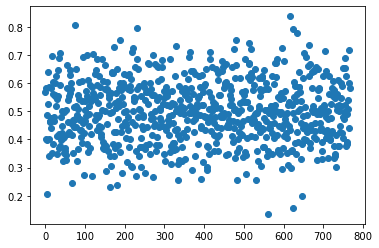

In [406]:
plt.scatter(range(len(X.T)),X.iloc[1,:])
plt.show()

### トレーニングデータとテストデータの分割

In [407]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.25, random_state=2, stratify=y)

In [408]:
print(f"X_train:{len(X_train)}\nX_test:{len(X_test)}\ny_train:{len(y_train)}\ny_test:{len(y_test)}")

X_train:26250
X_test:8750
y_train:26250
y_test:8750


### モデルの学習

In [409]:
# モデルの学習
model = lgb.LGBMClassifier() # モデルのインスタンスの作成
model.fit(X_train, y_train) # モデルの学習

# テストデータの予測クラス (予測クラス(-1 or 0 or 1)を返す)
y_pred = model.predict(X_test)
# テストデータのクラス予測確率 (各クラスの予測確率 [クラス0の予測確率,クラス1の予測確率,クラス2の予測確率] を返す)
y_pred_prob = model.predict_proba(X_test)

### 予測値の確認

In [410]:
# 真値と予測値の表示
df_pred = pd.DataFrame({'target':y_test,'target_pred':y_pred})
display(df_pred[20:30])

# 真値と予測確率の表示
df_pred_prob = pd.DataFrame({'y':y_test, '-1_prob':y_pred_prob[:,0], '0_prob':y_pred_prob[:,1], '1_prob':y_pred_prob[:,2]})
display(df_pred_prob[20:30])

,target,target_pred
28867,0,1
28798,-1,0
8608,1,1
421,1,1
26937,0,1
31089,1,1
28623,1,1
9137,0,-1
11646,-1,-1
13877,0,-1


,y,-1_prob,0_prob,1_prob
28867,0,0.060127,0.226014,0.713858
28798,-1,0.168894,0.762588,0.068517
8608,1,0.109706,0.154937,0.735357
421,1,0.050710,0.158412,0.790878
26937,0,0.143047,0.401403,0.455550
31089,1,0.114203,0.197802,0.687994
28623,1,0.018471,0.129023,0.852506
9137,0,0.565947,0.371614,0.062439
11646,-1,0.545909,0.364054,0.090037
13877,0,0.410477,0.255195,0.334328


In [411]:
pred_lgb = model.predict_proba(X)
df_lgb = pd.DataFrame(pred_lgb,columns=["lgb_-1","lgb_0","lgb_1"])
df_lgb

,lgb_-1,lgb_0,lgb_1
0,0.768978,0.126345,0.104676
1,0.494728,0.222561,0.282711
2,0.483829,0.423317,0.092854
3,0.775326,0.169800,0.054875
4,0.692333,0.259850,0.047817
...,...,...,...
34995,0.161745,0.282718,0.555537
34996,0.130140,0.237847,0.632013
34997,0.076420,0.190232,0.733349
34998,0.095907,0.150916,0.753177


In [173]:
df.iat[10334,0]

'業界地図が発売された。買おう。'

### モデルの評価

In [412]:
# モデル評価
# acc : 正答率
acc = accuracy_score(y_test,y_pred)
print('Acc :', acc)

Acc : 0.6150857142857142


## DNN

### インポート

In [31]:
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.keras.models import Model
from tensorflow.keras import layers, losses

In [32]:
#TensorFlowがGPUを認識しているか確認
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 11844910543690892632
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 4841275392
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 5968549719089090536
 physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1060, pci bus id: 0000:01:00.0, compute capability: 6.1"
 xla_global_id: 416903419]

### データの読み込み

In [33]:
df = pd.read_csv("../data/vector_split.csv",index_col=0)
df_status = pd.read_csv("../data/status.csv",index_col=0)
df_onehot = pd.read_csv("../data/onehot.csv",index_col=0)
display(df.head(1))
display(df_status.head(4))
display(df_onehot.head(1))

,text,sentiment,vector_0,vector_1,vector_2,vector_3,vector_4,vector_5,vector_6,vector_7,...,vector_758,vector_759,vector_760,vector_761,vector_762,vector_763,vector_764,vector_765,vector_766,vector_767
0,ぼけっとしてたらこんな時間。チャリあるから食べにでたいのに…,-1,-0.045897,-0.214199,-0.36531,-0.151727,-0.344921,-0.158282,0.058233,-0.224733,...,-0.042891,-0.457397,0.447057,-0.041747,-0.020145,-0.624823,-0.035998,-0.201487,0.255674,-0.37993


,vector_0,vector_1,vector_2,vector_3,vector_4,vector_5,vector_6,vector_7,vector_8,vector_9,...,vector_758,vector_759,vector_760,vector_761,vector_762,vector_763,vector_764,vector_765,vector_766,vector_767
mean,-0.008007,-0.094317,-0.054998,-0.165922,-0.142793,0.097898,0.038515,-0.033088,0.036804,-0.187420,...,-0.134448,-0.144797,0.266466,-0.010633,-0.065683,-0.392149,0.113740,-0.191146,0.054516,-0.052569
std,0.165550,0.167544,0.196841,0.152516,0.178113,0.173617,0.150423,0.172896,0.165181,0.175988,...,0.146223,0.168301,0.198516,0.154091,0.166551,0.200744,0.162681,0.159359,0.179604,0.177977
min,-1.085665,-1.788969,-1.314229,-0.976173,-1.014553,-0.678122,-0.772185,-1.355776,-0.819011,-0.991892,...,-1.030011,-1.337411,-1.123794,-0.983034,-0.760269,-1.652097,-1.003777,-0.945995,-1.784324,-1.296932
max,0.643333,0.996532,1.388678,0.964208,0.857462,2.048091,0.925388,0.711329,1.574542,0.854583,...,0.648653,1.145675,1.925123,1.253330,0.711414,0.666830,1.013699,0.971638,0.806236,0.904413


,sentiment_-1,sentiment_0,sentiment_1
0,1.0,0.0,0.0


### データの標準化

In [5]:
df_vector = df.iloc[:,2:]
display(df_vector.head())
for i in range(len(df_vector.T)):
    df_vector.iloc[:,i] = (df_vector.iloc[:,i] - df_status.iat[0,i]) / df_status.iat[1,i]
display(df_vector.head())

,vector_0,vector_1,vector_2,vector_3,vector_4,vector_5,vector_6,vector_7,vector_8,vector_9,...,vector_758,vector_759,vector_760,vector_761,vector_762,vector_763,vector_764,vector_765,vector_766,vector_767
0,-0.045897,-0.214199,-0.365310,-0.151727,-0.344921,-0.158282,0.058233,-0.224733,0.042998,-0.355706,...,-0.042891,-0.457397,0.447057,-0.041747,-0.020145,-0.624823,-0.035998,-0.201487,0.255674,-0.379930
1,-0.104059,-0.160933,-0.231748,-0.029837,-0.271681,-0.118083,0.118344,-0.036794,0.140905,-0.360428,...,0.022478,-0.362644,0.367586,-0.125338,0.032311,-0.476081,0.205891,-0.097674,0.078120,-0.010167
2,-0.078176,-0.217044,0.009032,-0.181265,-0.204240,-0.014866,0.061512,0.007916,-0.015457,-0.269055,...,-0.086051,-0.268181,0.442382,-0.166084,-0.284402,-0.398496,0.133986,-0.076781,0.113673,-0.274367
3,-0.046794,0.261336,0.102271,0.153345,-0.106192,-0.163717,0.163558,-0.248282,0.076741,-0.301016,...,0.036794,-0.467441,0.468574,-0.155915,0.446814,-0.676914,0.255677,-0.047488,-0.048264,-0.295006
4,-0.031411,-0.035217,-0.071406,-0.078532,-0.183378,0.052345,0.072138,-0.044480,-0.150694,-0.113329,...,-0.155673,-0.234942,0.440424,-0.027745,-0.007082,-0.463666,0.097027,-0.184296,0.132556,0.113567


,vector_0,vector_1,vector_2,vector_3,vector_4,vector_5,vector_6,vector_7,vector_8,vector_9,...,vector_758,vector_759,vector_760,vector_761,vector_762,vector_763,vector_764,vector_765,vector_766,vector_767
0,-0.228875,-0.715526,-1.576461,0.093063,-1.134828,-1.475550,0.131084,-1.108443,0.037497,-0.956243,...,0.626143,-1.857381,0.909698,-0.201921,0.273421,-1.159057,-0.920438,-0.064897,1.120010,-1.839351
1,-0.580202,-0.397605,-0.897938,0.892263,-0.723628,-1.244011,0.530700,-0.021437,0.630224,-0.983072,...,1.073200,-1.294386,0.509373,-0.744399,0.588369,-0.418103,0.566458,0.586548,0.131419,0.238240
2,-0.423857,-0.732506,0.325286,-0.100609,-0.344989,-0.649503,0.152881,0.237159,-0.316383,-0.463872,...,0.330980,-0.733111,0.886149,-1.008832,-1.313224,-0.031620,0.124453,0.717651,0.329373,-1.246223
3,-0.234298,2.122747,0.798961,2.093332,0.205495,-1.506854,0.831275,-1.244643,0.241774,-0.645482,...,1.171100,-1.917061,1.018089,-0.942834,3.077110,-1.418549,0.872493,0.901472,-0.572262,-1.362186
4,-0.141374,0.352747,-0.083357,0.572985,-0.227861,-0.262378,0.223525,-0.065887,-1.135102,0.420995,...,-0.145159,-0.535615,0.876287,-0.111056,0.351848,-0.356258,-0.102735,0.042978,0.434512,0.933469


### データの正規化

In [34]:
df_vector = df.iloc[:,2:]
display(df_vector.head())
for i in range(len(df_vector.T)):
    vec_min = df_status.iat[2,i]
    vec_max = df_status.iat[3,i]
    df_vector.iloc[:,i] = (df_vector.iloc[:,i] - vec_min) / (vec_max - vec_min)
display(df_vector.head())
df_vector.iloc[:,:5].std()

,vector_0,vector_1,vector_2,vector_3,vector_4,vector_5,vector_6,vector_7,vector_8,vector_9,...,vector_758,vector_759,vector_760,vector_761,vector_762,vector_763,vector_764,vector_765,vector_766,vector_767
0,-0.045897,-0.214199,-0.365310,-0.151727,-0.344921,-0.158282,0.058233,-0.224733,0.042998,-0.355706,...,-0.042891,-0.457397,0.447057,-0.041747,-0.020145,-0.624823,-0.035998,-0.201487,0.255674,-0.379930
1,-0.104059,-0.160933,-0.231748,-0.029837,-0.271681,-0.118083,0.118344,-0.036794,0.140905,-0.360428,...,0.022478,-0.362644,0.367586,-0.125338,0.032311,-0.476081,0.205891,-0.097674,0.078120,-0.010167
2,-0.078176,-0.217044,0.009032,-0.181265,-0.204240,-0.014866,0.061512,0.007916,-0.015457,-0.269055,...,-0.086051,-0.268181,0.442382,-0.166084,-0.284402,-0.398496,0.133986,-0.076781,0.113673,-0.274367
3,-0.046794,0.261336,0.102271,0.153345,-0.106192,-0.163717,0.163558,-0.248282,0.076741,-0.301016,...,0.036794,-0.467441,0.468574,-0.155915,0.446814,-0.676914,0.255677,-0.047488,-0.048264,-0.295006
4,-0.031411,-0.035217,-0.071406,-0.078532,-0.183378,0.052345,0.072138,-0.044480,-0.150694,-0.113329,...,-0.155673,-0.234942,0.440424,-0.027745,-0.007082,-0.463666,0.097027,-0.184296,0.132556,0.113567


,vector_0,vector_1,vector_2,vector_3,vector_4,vector_5,vector_6,vector_7,vector_8,vector_9,...,vector_758,vector_759,vector_760,vector_761,vector_762,vector_763,vector_764,vector_765,vector_766,vector_767
0,0.601370,0.565345,0.351074,0.424889,0.357707,0.190682,0.489180,0.547163,0.360138,0.344540,...,0.588039,0.354404,0.515216,0.420901,0.502910,0.442996,0.479698,0.388243,0.787474,0.416565
1,0.567731,0.584468,0.400488,0.487706,0.396830,0.205427,0.524590,0.638082,0.401043,0.341983,...,0.626980,0.392563,0.489151,0.383523,0.538553,0.507138,0.599595,0.442379,0.718935,0.584536
2,0.582701,0.564324,0.489570,0.409666,0.432856,0.243288,0.491111,0.659711,0.335716,0.391468,...,0.562328,0.430605,0.513683,0.365303,0.323349,0.540595,0.563954,0.453274,0.732659,0.464518
3,0.600851,0.736063,0.524065,0.582111,0.485232,0.188688,0.551224,0.535771,0.374235,0.374159,...,0.635508,0.350358,0.522273,0.369850,0.820206,0.420532,0.624272,0.468550,0.670148,0.455143
4,0.609749,0.629600,0.459810,0.462611,0.444000,0.267942,0.497371,0.634364,0.279216,0.475805,...,0.520853,0.443992,0.513041,0.427161,0.511786,0.512492,0.545634,0.397208,0.739948,0.640744


vector_0    0.095749
vector_1    0.060149
vector_2    0.072826
vector_3    0.078601
vector_4    0.095145
dtype: float64

### 説明変数と目的変数

In [217]:
X = df_vector.to_numpy()
y = df_onehot.to_numpy()

In [218]:
X

array([[0.60137046, 0.56534523, 0.35107366, ..., 0.3882432 , 0.78747378,
        0.41656461],
       [0.56773128, 0.58446776, 0.40048753, ..., 0.44237944, 0.71893473,
        0.58453575],
       [0.58270116, 0.56432395, 0.48956961, ..., 0.45327435, 0.73265889,
        0.4645184 ],
       ...,
       [0.60534403, 0.49412094, 0.51222055, ..., 0.48102556, 0.67942046,
        0.52628356],
       [0.50013872, 0.52910082, 0.45617261, ..., 0.42571698, 0.68143303,
        0.52084663],
       [0.56706806, 0.64077189, 0.53172974, ..., 0.32005251, 0.60365537,
        0.59993223]])

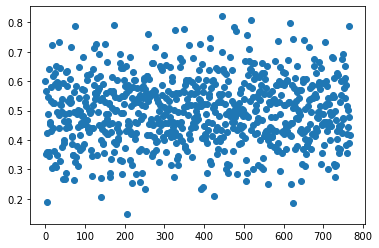

In [219]:
plt.scatter(range(len(X.T)),X[0])
plt.show()

### トレーニングデータとテストデータの分割

In [220]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.25, random_state=2)

In [221]:
print(f"X_train:{len(X_train)}\nX_test:{len(X_test)}\ny_train:{len(y_train)}\ny_test:{len(y_test)}")

X_train:26250
X_test:8750
y_train:26250
y_test:8750


## オートエンコーダ

In [228]:
latent_dim = 50

class Autoencoder(Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim   
        self.encoder = tf.keras.Sequential([
#             layers.Dense(600, activation='relu'),
#             layers.Dense(200, activation='relu'),
            layers.Dense(latent_dim, activation='tanh'),
        ])
        self.decoder = tf.keras.Sequential([
#             layers.Dense(200, activation='relu'),
#             layers.Dense(600, activation='relu'),
            layers.Dense(768, activation='sigmoid'),
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = Autoencoder(latent_dim)

autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [229]:
result = autoencoder.fit(X_train, X_train,
                         epochs=150,
                         batch_size=1000, 
                         shuffle=True,
                         validation_data=(X_test, X_test))

Epoch 1/150
27/27 [==============================] - 1s 18ms/step - loss: 0.0102 - val_loss: 0.0074
Epoch 2/150
27/27 [==============================] - 0s 11ms/step - loss: 0.0071 - val_loss: 0.0070
Epoch 3/150
27/27 [==============================] - 0s 11ms/step - loss: 0.0068 - val_loss: 0.0068
Epoch 4/150
27/27 [==============================] - 0s 11ms/step - loss: 0.0065 - val_loss: 0.0065
Epoch 5/150
27/27 [==============================] - 0s 8ms/step - loss: 0.0063 - val_loss: 0.0062
Epoch 6/150
27/27 [==============================] - 0s 7ms/step - loss: 0.0061 - val_loss: 0.0060
Epoch 7/150
27/27 [==============================] - 0s 8ms/step - loss: 0.0059 - val_loss: 0.0058
Epoch 8/150
27/27 [==============================] - 0s 9ms/step - loss: 0.0057 - val_loss: 0.0057
Epoch 9/150
27/27 [==============================] - 0s 8ms/step - loss: 0.0055 - val_loss: 0.0055
Epoch 10/150
27/27 [==============================] - 0s 8ms/step - loss: 0.0054 - val_loss: 0.0053
Epoch

Epoch 83/150
27/27 [==============================] - 0s 8ms/step - loss: 0.0032 - val_loss: 0.0033
Epoch 84/150
27/27 [==============================] - 0s 7ms/step - loss: 0.0032 - val_loss: 0.0033
Epoch 85/150
27/27 [==============================] - 0s 9ms/step - loss: 0.0032 - val_loss: 0.0033
Epoch 86/150
27/27 [==============================] - 0s 8ms/step - loss: 0.0032 - val_loss: 0.0033
Epoch 87/150
27/27 [==============================] - 0s 8ms/step - loss: 0.0032 - val_loss: 0.0033
Epoch 88/150
27/27 [==============================] - 0s 8ms/step - loss: 0.0032 - val_loss: 0.0033
Epoch 89/150
27/27 [==============================] - 0s 8ms/step - loss: 0.0032 - val_loss: 0.0033
Epoch 90/150
27/27 [==============================] - 0s 9ms/step - loss: 0.0032 - val_loss: 0.0033
Epoch 91/150
27/27 [==============================] - 0s 9ms/step - loss: 0.0032 - val_loss: 0.0033
Epoch 92/150
27/27 [==============================] - 0s 9ms/step - loss: 0.0032 - val_loss: 0.0033


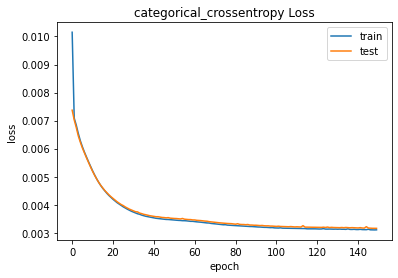

In [230]:
# Lossのプロット
plt.figure()
plt.title('categorical_crossentropy Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(result.history['loss'], label='train')
plt.plot(result.history['val_loss'], label='test')
plt.legend()
plt.show()

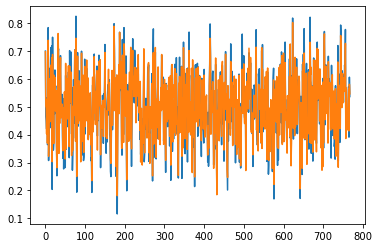

In [231]:
encoded = autoencoder.encoder(X_test).numpy()
decoded = autoencoder.decoder(encoded).numpy()
plt.plot(X_test[0])
plt.plot(decoded[0])
plt.show()
# print(X_test[0][:10])
# print(decoded[0][:10])

In [232]:
# model.evaluateを使用し、学習を終えたモデルの誤差と精度を呼び出し
train_score = autoencoder.evaluate(X_train, X_train)
test_score = autoencoder.evaluate(X_test, X_test)
print('Train loss:', train_score)
# print('Train accuracy:', train_score)
print('Test loss:', test_score)
# print('Test accuracy:', test_score)

274/274 [==============================] - 1s 2ms/step - loss: 0.0032
Train loss: 0.0030990121886134148
Test loss: 0.003158367006108165


In [233]:
encoded = autoencoder.encoder(X).numpy()
_df = pd.DataFrame(encoded)
df_nozero = pd.DataFrame()
for i in range(len(_df.T)):
    if _df.iloc[:,i].max() != 0:
        df_nozero[f"vector_{i}"] = _df.iloc[:,i]
df_nozero.head()

,vector_0,vector_1,vector_2,vector_3,vector_4,vector_5,vector_6,vector_7,vector_8,vector_9,...,vector_40,vector_41,vector_42,vector_43,vector_44,vector_45,vector_46,vector_47,vector_48,vector_49
0,-0.273669,0.064362,0.070113,-0.023050,-0.221182,-0.293196,-0.288420,-0.106090,-0.256128,0.289271,...,0.121675,-0.177222,-0.278945,-0.364331,-0.178745,0.082578,0.104390,-0.135253,-0.063475,-0.644525
1,0.100604,-0.057377,0.595226,-0.459057,-0.421028,0.196519,0.170491,-0.079071,-0.111378,-0.179704,...,-0.203608,-0.462240,-0.016065,-0.021387,-0.248944,0.249913,0.432996,-0.088099,-0.308374,0.231022
2,0.103975,-0.343163,0.034828,-0.266872,-0.287063,0.332721,-0.294678,-0.456746,-0.114124,-0.208367,...,0.118624,-0.290509,0.135650,-0.316308,-0.214655,0.284327,0.174844,-0.213929,-0.315857,0.021526
3,-0.052286,0.178584,0.199921,-0.693820,-0.539344,0.170665,-0.086629,0.539825,0.288434,-0.711333,...,-0.037604,-0.658899,0.072032,-0.359510,0.304917,0.488733,0.209213,-0.329669,-0.195116,-0.328314
4,-0.296032,-0.002406,0.173074,0.203902,-0.354538,-0.049283,-0.319726,0.237600,0.029418,0.017913,...,0.158160,0.011476,-0.297052,-0.472597,-0.428390,0.038311,0.412237,0.144034,-0.497902,-0.023044


In [234]:
df_nozero

,vector_0,vector_1,vector_2,vector_3,vector_4,vector_5,vector_6,vector_7,vector_8,vector_9,...,vector_40,vector_41,vector_42,vector_43,vector_44,vector_45,vector_46,vector_47,vector_48,vector_49
0,-0.273669,0.064362,0.070113,-0.023050,-0.221182,-0.293196,-0.288420,-0.106090,-0.256128,0.289271,...,0.121675,-0.177222,-0.278945,-0.364331,-0.178745,0.082578,0.104390,-0.135253,-0.063475,-0.644525
1,0.100604,-0.057377,0.595226,-0.459057,-0.421028,0.196519,0.170491,-0.079071,-0.111378,-0.179704,...,-0.203608,-0.462240,-0.016065,-0.021387,-0.248944,0.249913,0.432996,-0.088099,-0.308374,0.231022
2,0.103975,-0.343163,0.034828,-0.266872,-0.287063,0.332721,-0.294678,-0.456746,-0.114124,-0.208367,...,0.118624,-0.290509,0.135650,-0.316308,-0.214655,0.284327,0.174844,-0.213929,-0.315857,0.021526
3,-0.052286,0.178584,0.199921,-0.693820,-0.539344,0.170665,-0.086629,0.539825,0.288434,-0.711333,...,-0.037604,-0.658899,0.072032,-0.359510,0.304917,0.488733,0.209213,-0.329669,-0.195116,-0.328314
4,-0.296032,-0.002406,0.173074,0.203902,-0.354538,-0.049283,-0.319726,0.237600,0.029418,0.017913,...,0.158160,0.011476,-0.297052,-0.472597,-0.428390,0.038311,0.412237,0.144034,-0.497902,-0.023044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34995,0.209398,-0.397170,0.006804,-0.231847,-0.403514,0.221742,-0.282228,-0.434839,0.029081,-0.208387,...,0.107321,0.018028,-0.218770,-0.463807,-0.328601,-0.007443,-0.052756,-0.376397,0.043278,-0.447443
34996,0.102495,-0.352107,0.661464,-0.191218,-0.405871,-0.414145,0.009154,0.027934,-0.097815,-0.001100,...,-0.296521,-0.828360,-0.083615,-0.451998,-0.065262,0.251072,0.467437,-0.311353,-0.199544,-0.018644
34997,0.273098,-0.491650,0.041559,-0.342709,-0.550501,0.063226,0.346149,-0.327683,0.399823,-0.056262,...,0.354542,-0.109823,-0.073000,0.215954,-0.475074,0.125794,0.070825,0.020132,0.245138,0.050887
34998,0.261964,-0.071256,-0.044003,-0.202784,-0.477218,0.370567,-0.056379,-0.339119,0.281325,-0.142520,...,-0.179521,-0.708113,-0.252064,-0.322323,0.042974,0.261804,0.101423,0.252941,-0.009508,-0.179778


### 説明変数と目的変数２

In [444]:
X = df_vector.to_numpy()
y = df_onehot.to_numpy()

In [445]:
X[0]

array([0.60137046, 0.56534523, 0.35107366, 0.42488866, 0.35770651,
       0.19068208, 0.48917964, 0.54716274, 0.36013788, 0.34454044,
       0.64239427, 0.46168688, 0.45421619, 0.58010936, 0.53415096,
       0.43110749, 0.7246129 , 0.30614685, 0.61863566, 0.5267789 ,
       0.43919215, 0.52627734, 0.36132019, 0.62912535, 0.59132988,
       0.3162176 , 0.65015255, 0.30946409, 0.34960125, 0.4951797 ,
       0.59849839, 0.57950503, 0.59415816, 0.7340306 , 0.48574078,
       0.44192044, 0.32755664, 0.5234029 , 0.64342669, 0.51844498,
       0.49619448, 0.37765093, 0.49547474, 0.53874538, 0.26656944,
       0.59450364, 0.39043479, 0.39884245, 0.46390309, 0.48752527,
       0.26774431, 0.62980214, 0.28799205, 0.44142612, 0.63489495,
       0.58259438, 0.46627173, 0.45253331, 0.53176842, 0.49131633,
       0.4442892 , 0.52483817, 0.60828019, 0.54443905, 0.71656717,
       0.52893019, 0.4149501 , 0.38762202, 0.41083226, 0.34858799,
       0.34874519, 0.56486177, 0.26390023, 0.49549145, 0.78598

### トレーニングデータとテストデータの分割２

In [446]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.25, random_state=2,stratify=y)

In [447]:
print(f"X_train:{len(X_train)}\nX_test:{len(X_test)}\ny_train:{len(y_train)}\ny_test:{len(y_test)}")

X_train:26250
X_test:8750
y_train:26250
y_test:8750


### モデルの準備

In [448]:
len(X_train[0])

768

In [449]:
dr = 0.2
len_X = len(X_train[0])
model = Sequential(
    [
        Input(shape=(len_X,)),
#         Dense(len_X,activation="relu"),
#         Dense(10,activation="relu"),
        Dense(len_X,activation="sigmoid"),
        Dropout(dr),
        Dense(3,activation="softmax")
    ]
)

#モデルのサマリ(全体像)を表示
model.summary()

#コンパイル
model.compile(optimizer = Adam(),
              loss = 'categorical_crossentropy',
              metrics=['categorical_accuracy'])

Model: "sequential_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_129 (Dense)           (None, 768)               590592    
                                                                 
 dropout_35 (Dropout)        (None, 768)               0         
                                                                 
 dense_130 (Dense)           (None, 3)                 2307      
                                                                 
Total params: 592,899
Trainable params: 592,899
Non-trainable params: 0
_________________________________________________________________


### モデルの学習

In [450]:
result = model.fit(
    X_train,                #訓練データ
    y_train,                #ラベル
    epochs = 500,     #エポック数
    batch_size = 5000,    #ミニバッチのサイズ
    verbose = 2,
    validation_data=(X_test, y_test)
)

Epoch 1/500
6/6 - 1s - loss: 1.4835 - categorical_accuracy: 0.3354 - val_loss: 1.2313 - val_categorical_accuracy: 0.3533 - 768ms/epoch - 128ms/step
Epoch 2/500
6/6 - 0s - loss: 1.2614 - categorical_accuracy: 0.3272 - val_loss: 1.1115 - val_categorical_accuracy: 0.3562 - 120ms/epoch - 20ms/step
Epoch 3/500
6/6 - 0s - loss: 1.1953 - categorical_accuracy: 0.3487 - val_loss: 1.1292 - val_categorical_accuracy: 0.3253 - 121ms/epoch - 20ms/step
Epoch 4/500
6/6 - 0s - loss: 1.1561 - categorical_accuracy: 0.3409 - val_loss: 1.1257 - val_categorical_accuracy: 0.3473 - 125ms/epoch - 21ms/step
Epoch 5/500
6/6 - 0s - loss: 1.1325 - categorical_accuracy: 0.3550 - val_loss: 1.0914 - val_categorical_accuracy: 0.3255 - 123ms/epoch - 21ms/step
Epoch 6/500
6/6 - 0s - loss: 1.1177 - categorical_accuracy: 0.3673 - val_loss: 1.0740 - val_categorical_accuracy: 0.4219 - 120ms/epoch - 20ms/step
Epoch 7/500
6/6 - 0s - loss: 1.1058 - categorical_accuracy: 0.3693 - val_loss: 1.0717 - val_categorical_accuracy: 0.4

Epoch 57/500
6/6 - 0s - loss: 0.8915 - categorical_accuracy: 0.5842 - val_loss: 0.8795 - val_categorical_accuracy: 0.6041 - 125ms/epoch - 21ms/step
Epoch 58/500
6/6 - 0s - loss: 0.8896 - categorical_accuracy: 0.5893 - val_loss: 0.8815 - val_categorical_accuracy: 0.5920 - 124ms/epoch - 21ms/step
Epoch 59/500
6/6 - 0s - loss: 0.8896 - categorical_accuracy: 0.5841 - val_loss: 0.8738 - val_categorical_accuracy: 0.6024 - 124ms/epoch - 21ms/step
Epoch 60/500
6/6 - 0s - loss: 0.8834 - categorical_accuracy: 0.5894 - val_loss: 0.8735 - val_categorical_accuracy: 0.5998 - 125ms/epoch - 21ms/step
Epoch 61/500
6/6 - 0s - loss: 0.8831 - categorical_accuracy: 0.5910 - val_loss: 0.8728 - val_categorical_accuracy: 0.6042 - 131ms/epoch - 22ms/step
Epoch 62/500
6/6 - 0s - loss: 0.8820 - categorical_accuracy: 0.5904 - val_loss: 0.8743 - val_categorical_accuracy: 0.5994 - 129ms/epoch - 21ms/step
Epoch 63/500
6/6 - 0s - loss: 0.8837 - categorical_accuracy: 0.5855 - val_loss: 0.8728 - val_categorical_accurac

Epoch 113/500
6/6 - 0s - loss: 0.8557 - categorical_accuracy: 0.6049 - val_loss: 0.8486 - val_categorical_accuracy: 0.6119 - 125ms/epoch - 21ms/step
Epoch 114/500
6/6 - 0s - loss: 0.8492 - categorical_accuracy: 0.6077 - val_loss: 0.8503 - val_categorical_accuracy: 0.6071 - 125ms/epoch - 21ms/step
Epoch 115/500
6/6 - 0s - loss: 0.8476 - categorical_accuracy: 0.6083 - val_loss: 0.8477 - val_categorical_accuracy: 0.6115 - 122ms/epoch - 20ms/step
Epoch 116/500
6/6 - 0s - loss: 0.8469 - categorical_accuracy: 0.6071 - val_loss: 0.8397 - val_categorical_accuracy: 0.6137 - 128ms/epoch - 21ms/step
Epoch 117/500
6/6 - 0s - loss: 0.8433 - categorical_accuracy: 0.6133 - val_loss: 0.8415 - val_categorical_accuracy: 0.6139 - 127ms/epoch - 21ms/step
Epoch 118/500
6/6 - 0s - loss: 0.8490 - categorical_accuracy: 0.6077 - val_loss: 0.8530 - val_categorical_accuracy: 0.6058 - 123ms/epoch - 20ms/step
Epoch 119/500
6/6 - 0s - loss: 0.8498 - categorical_accuracy: 0.6074 - val_loss: 0.8517 - val_categorical_

Epoch 168/500
6/6 - 0s - loss: 0.8304 - categorical_accuracy: 0.6194 - val_loss: 0.8293 - val_categorical_accuracy: 0.6198 - 122ms/epoch - 20ms/step
Epoch 169/500
6/6 - 0s - loss: 0.8297 - categorical_accuracy: 0.6169 - val_loss: 0.8294 - val_categorical_accuracy: 0.6195 - 124ms/epoch - 21ms/step
Epoch 170/500
6/6 - 0s - loss: 0.8285 - categorical_accuracy: 0.6198 - val_loss: 0.8306 - val_categorical_accuracy: 0.6211 - 122ms/epoch - 20ms/step
Epoch 171/500
6/6 - 0s - loss: 0.8294 - categorical_accuracy: 0.6179 - val_loss: 0.8332 - val_categorical_accuracy: 0.6168 - 123ms/epoch - 21ms/step
Epoch 172/500
6/6 - 0s - loss: 0.8303 - categorical_accuracy: 0.6172 - val_loss: 0.8301 - val_categorical_accuracy: 0.6176 - 121ms/epoch - 20ms/step
Epoch 173/500
6/6 - 0s - loss: 0.8281 - categorical_accuracy: 0.6188 - val_loss: 0.8312 - val_categorical_accuracy: 0.6209 - 125ms/epoch - 21ms/step
Epoch 174/500
6/6 - 0s - loss: 0.8340 - categorical_accuracy: 0.6170 - val_loss: 0.8277 - val_categorical_

Epoch 223/500
6/6 - 0s - loss: 0.8246 - categorical_accuracy: 0.6208 - val_loss: 0.8237 - val_categorical_accuracy: 0.6225 - 129ms/epoch - 21ms/step
Epoch 224/500
6/6 - 0s - loss: 0.8224 - categorical_accuracy: 0.6234 - val_loss: 0.8299 - val_categorical_accuracy: 0.6181 - 124ms/epoch - 21ms/step
Epoch 225/500
6/6 - 0s - loss: 0.8230 - categorical_accuracy: 0.6237 - val_loss: 0.8248 - val_categorical_accuracy: 0.6193 - 125ms/epoch - 21ms/step
Epoch 226/500
6/6 - 0s - loss: 0.8198 - categorical_accuracy: 0.6232 - val_loss: 0.8226 - val_categorical_accuracy: 0.6216 - 128ms/epoch - 21ms/step
Epoch 227/500
6/6 - 0s - loss: 0.8176 - categorical_accuracy: 0.6248 - val_loss: 0.8230 - val_categorical_accuracy: 0.6222 - 147ms/epoch - 24ms/step
Epoch 228/500
6/6 - 0s - loss: 0.8212 - categorical_accuracy: 0.6263 - val_loss: 0.8236 - val_categorical_accuracy: 0.6207 - 145ms/epoch - 24ms/step
Epoch 229/500
6/6 - 0s - loss: 0.8200 - categorical_accuracy: 0.6246 - val_loss: 0.8209 - val_categorical_

Epoch 278/500
6/6 - 0s - loss: 0.8175 - categorical_accuracy: 0.6236 - val_loss: 0.8178 - val_categorical_accuracy: 0.6227 - 126ms/epoch - 21ms/step
Epoch 279/500
6/6 - 0s - loss: 0.8198 - categorical_accuracy: 0.6242 - val_loss: 0.8248 - val_categorical_accuracy: 0.6189 - 128ms/epoch - 21ms/step
Epoch 280/500
6/6 - 0s - loss: 0.8137 - categorical_accuracy: 0.6261 - val_loss: 0.8168 - val_categorical_accuracy: 0.6262 - 125ms/epoch - 21ms/step
Epoch 281/500
6/6 - 0s - loss: 0.8133 - categorical_accuracy: 0.6278 - val_loss: 0.8236 - val_categorical_accuracy: 0.6189 - 125ms/epoch - 21ms/step
Epoch 282/500
6/6 - 0s - loss: 0.8150 - categorical_accuracy: 0.6267 - val_loss: 0.8164 - val_categorical_accuracy: 0.6250 - 126ms/epoch - 21ms/step
Epoch 283/500
6/6 - 0s - loss: 0.8145 - categorical_accuracy: 0.6267 - val_loss: 0.8270 - val_categorical_accuracy: 0.6222 - 127ms/epoch - 21ms/step
Epoch 284/500
6/6 - 0s - loss: 0.8168 - categorical_accuracy: 0.6266 - val_loss: 0.8206 - val_categorical_

Epoch 333/500
6/6 - 0s - loss: 0.8103 - categorical_accuracy: 0.6290 - val_loss: 0.8217 - val_categorical_accuracy: 0.6273 - 125ms/epoch - 21ms/step
Epoch 334/500
6/6 - 0s - loss: 0.8138 - categorical_accuracy: 0.6281 - val_loss: 0.8193 - val_categorical_accuracy: 0.6219 - 125ms/epoch - 21ms/step
Epoch 335/500
6/6 - 0s - loss: 0.8085 - categorical_accuracy: 0.6316 - val_loss: 0.8168 - val_categorical_accuracy: 0.6271 - 130ms/epoch - 22ms/step
Epoch 336/500
6/6 - 0s - loss: 0.8100 - categorical_accuracy: 0.6301 - val_loss: 0.8277 - val_categorical_accuracy: 0.6171 - 127ms/epoch - 21ms/step
Epoch 337/500
6/6 - 0s - loss: 0.8148 - categorical_accuracy: 0.6250 - val_loss: 0.8196 - val_categorical_accuracy: 0.6258 - 127ms/epoch - 21ms/step
Epoch 338/500
6/6 - 0s - loss: 0.8151 - categorical_accuracy: 0.6252 - val_loss: 0.8254 - val_categorical_accuracy: 0.6202 - 126ms/epoch - 21ms/step
Epoch 339/500
6/6 - 0s - loss: 0.8168 - categorical_accuracy: 0.6277 - val_loss: 0.8150 - val_categorical_

Epoch 388/500
6/6 - 0s - loss: 0.8093 - categorical_accuracy: 0.6282 - val_loss: 0.8264 - val_categorical_accuracy: 0.6169 - 141ms/epoch - 23ms/step
Epoch 389/500
6/6 - 0s - loss: 0.8127 - categorical_accuracy: 0.6287 - val_loss: 0.8270 - val_categorical_accuracy: 0.6250 - 147ms/epoch - 25ms/step
Epoch 390/500
6/6 - 0s - loss: 0.8083 - categorical_accuracy: 0.6294 - val_loss: 0.8140 - val_categorical_accuracy: 0.6255 - 148ms/epoch - 25ms/step
Epoch 391/500
6/6 - 0s - loss: 0.8049 - categorical_accuracy: 0.6329 - val_loss: 0.8194 - val_categorical_accuracy: 0.6230 - 139ms/epoch - 23ms/step
Epoch 392/500
6/6 - 0s - loss: 0.8068 - categorical_accuracy: 0.6323 - val_loss: 0.8224 - val_categorical_accuracy: 0.6222 - 131ms/epoch - 22ms/step
Epoch 393/500
6/6 - 0s - loss: 0.8103 - categorical_accuracy: 0.6285 - val_loss: 0.8497 - val_categorical_accuracy: 0.6089 - 135ms/epoch - 23ms/step
Epoch 394/500
6/6 - 0s - loss: 0.8202 - categorical_accuracy: 0.6241 - val_loss: 0.8255 - val_categorical_

Epoch 443/500
6/6 - 0s - loss: 0.8031 - categorical_accuracy: 0.6341 - val_loss: 0.8113 - val_categorical_accuracy: 0.6262 - 113ms/epoch - 19ms/step
Epoch 444/500
6/6 - 0s - loss: 0.8000 - categorical_accuracy: 0.6357 - val_loss: 0.8084 - val_categorical_accuracy: 0.6318 - 116ms/epoch - 19ms/step
Epoch 445/500
6/6 - 0s - loss: 0.7989 - categorical_accuracy: 0.6365 - val_loss: 0.8117 - val_categorical_accuracy: 0.6328 - 112ms/epoch - 19ms/step
Epoch 446/500
6/6 - 0s - loss: 0.8027 - categorical_accuracy: 0.6309 - val_loss: 0.8290 - val_categorical_accuracy: 0.6165 - 113ms/epoch - 19ms/step
Epoch 447/500
6/6 - 0s - loss: 0.8109 - categorical_accuracy: 0.6286 - val_loss: 0.8097 - val_categorical_accuracy: 0.6317 - 115ms/epoch - 19ms/step
Epoch 448/500
6/6 - 0s - loss: 0.8096 - categorical_accuracy: 0.6282 - val_loss: 0.8105 - val_categorical_accuracy: 0.6286 - 113ms/epoch - 19ms/step
Epoch 449/500
6/6 - 0s - loss: 0.8029 - categorical_accuracy: 0.6296 - val_loss: 0.8126 - val_categorical_

Epoch 498/500
6/6 - 0s - loss: 0.8026 - categorical_accuracy: 0.6324 - val_loss: 0.8107 - val_categorical_accuracy: 0.6307 - 114ms/epoch - 19ms/step
Epoch 499/500
6/6 - 0s - loss: 0.7976 - categorical_accuracy: 0.6344 - val_loss: 0.8093 - val_categorical_accuracy: 0.6311 - 108ms/epoch - 18ms/step
Epoch 500/500
6/6 - 0s - loss: 0.7960 - categorical_accuracy: 0.6361 - val_loss: 0.8117 - val_categorical_accuracy: 0.6326 - 120ms/epoch - 20ms/step


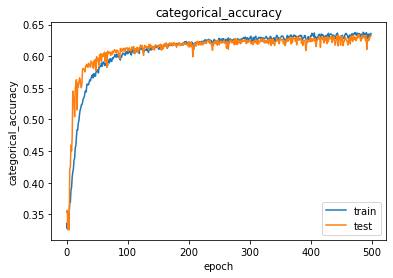

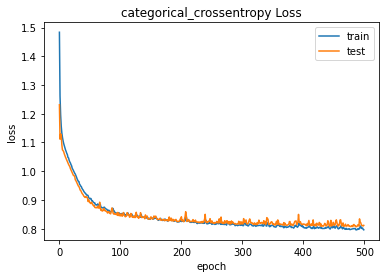

In [451]:
# Accuracyのプロット
plt.figure()
plt.title('categorical_accuracy')
plt.xlabel('epoch')
plt.ylabel('categorical_accuracy')
plt.plot(result.history['categorical_accuracy'], label='train')
plt.plot(result.history['val_categorical_accuracy'], label='test')
plt.legend()

# Lossのプロット
plt.figure()
plt.title('categorical_crossentropy Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(result.history['loss'], label='train')
plt.plot(result.history['val_loss'], label='test')
plt.legend()
plt.show()

In [452]:
# model.evaluateを使用し、学習を終えたモデルの誤差と精度を呼び出し
train_score = model.evaluate(X_train, y_train)
test_score = model.evaluate(X_test, y_test)
print('Train loss:', train_score[0])
print('Train accuracy:', train_score[1])
print('Test loss:', test_score[0])
print('Test accuracy:', test_score[1])

274/274 [==============================] - 1s 2ms/step - loss: 0.8117 - categorical_accuracy: 0.6326
Train loss: 0.7921148538589478
Train accuracy: 0.6397714018821716
Test loss: 0.8116576671600342
Test accuracy: 0.6325713992118835


In [453]:
pred_dnn = model.predict(X)

1094/1094 [==============================] - 1s 1ms/step


In [454]:
df_dnn = pd.DataFrame(pred_dnn,columns=["dnn_-1","dnn_0","dnn_1"])
df_dnn

,dnn_-1,dnn_0,dnn_1
0,0.715113,0.169242,0.115646
1,0.494646,0.196754,0.308599
2,0.646702,0.266640,0.086658
3,0.942478,0.045158,0.012364
4,0.766578,0.125416,0.108006
...,...,...,...
34995,0.145112,0.280480,0.574409
34996,0.101820,0.189234,0.708946
34997,0.045401,0.159488,0.795111
34998,0.100297,0.165046,0.734657


In [455]:
_ = pd.concat([df.iloc[:,:2],df_dnn,df_lgb,df_clf],axis = 1)
_["-1"] = (_["dnn_-1"] + _["lgb_-1"] + _["clf_-1"])/3
_["0"] = (_["dnn_0"] + _["lgb_0"] + _["clf_0"])/3
_["1"] = (_["dnn_1"] + _["lgb_1"] + _["clf_1"])/3
# _["-1"] = (_["clf_-1"] + _["dnn_-1"])/2
# _["0"] = (_["clf_0"] + _["dnn_0"])/2
# _["1"] = (_["clf_1"] + _["dnn_1"])/2
pred = []
for i in range(len(_)):
    pred.append(_.iloc[i,-3:].to_numpy().argmax() -1)
_["pred"] = pred
_.head(1)

,text,sentiment,dnn_-1,dnn_0,dnn_1,lgb_-1,lgb_0,lgb_1,clf_-1,clf_0,clf_1,-1,0,1,pred
0,ぼけっとしてたらこんな時間。チャリあるから食べにでたいのに…,-1,0.715113,0.169242,0.115646,0.768978,0.126345,0.104676,0.776727,0.15421,0.069063,0.753606,0.149932,0.096462,-1


In [456]:
a = 0
for sent,pred in zip(_["sentiment"],_["pred"]):
    if sent == pred:
        a += 1
print(f"正答率：{a / len(_) * 100}％")

正答率：71.36571428571429％


In [337]:
_.iloc[:,-3:].to_numpy()

array([[0.71938917, 0.16099689, 0.11961395],
       [0.51477983, 0.29264332, 0.19257686],
       [0.70496064, 0.22427121, 0.07076814],
       ...,
       [0.09410332, 0.20870855, 0.69718814],
       [0.16436877, 0.24938477, 0.58624647],
       [0.03670039, 0.1243833 , 0.83891631]])

## 決定木
参考：  
https://qiita.com/renesisu727/items/844648d6c60e578ce944

### 説明変数と目的変数

In [415]:
X = df_vector
y = df["sentiment"]

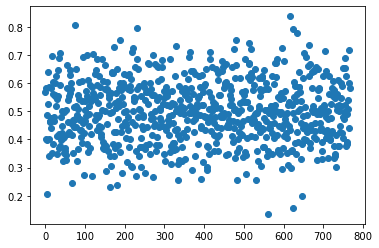

In [416]:
plt.scatter(range(len(X.T)),X.iloc[1,:])
plt.show()

In [417]:
from sklearn.tree import DecisionTreeClassifier

In [418]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, stratify=y)

In [440]:
b = []
for i in range(10):
    clf_model = DecisionTreeClassifier(max_depth=i+1)
    clf_model.fit(X_train, y_train)
    b.append({"depth":i+1,"score":clf_model.score(X_test, y_test)})
    print(f"max_depth:{i+1},score:{clf_model.score(X_test, y_test)}")
_df = pd.DataFrame(b)
depth = _df[_df["score"] == _df["score"].max()].iat[0,0]

clf_model = DecisionTreeClassifier(max_depth=depth)
clf_model.fit(X_train, y_train)

max_depth:1,score:0.41668571428571427
max_depth:2,score:0.4377142857142857
max_depth:3,score:0.45565714285714287
max_depth:4,score:0.46891428571428573
max_depth:5,score:0.4819428571428571
max_depth:6,score:0.48514285714285715
max_depth:7,score:0.48137142857142856
max_depth:8,score:0.4856
max_depth:9,score:0.4728
max_depth:10,score:0.47005714285714284


DecisionTreeClassifier(max_depth=8)

In [441]:
df_clf = pd.DataFrame(clf_model.predict_proba(X),columns=["clf_-1","clf_0","clf_1"])
df_clf

,clf_-1,clf_0,clf_1
0,0.776727,0.154210,0.069063
1,0.423729,0.330508,0.245763
2,0.331593,0.394256,0.274151
3,0.592949,0.237179,0.169872
4,0.488152,0.407583,0.104265
...,...,...,...
34995,0.379913,0.366812,0.253275
34996,0.774725,0.181319,0.043956
34997,0.113537,0.327511,0.558952
34998,0.244444,0.066667,0.688889


### 文章の置き換え

#### 英語に変換

In [17]:
df_temp = df[:10000]
# df_temp = df[10000:20000]
# df_temp = df[20000:30000]
# df_temp = df[30000:]
temp = []

for text, sentiment in zip(df_temp["text"], df_temp["sentiment"]):
    text_trans = translator.translate(text)
    dict_temp = {"text":text_trans.text, "sentiment":sentiment}
    temp.append(dict_temp)
    time.sleep(0.5)
    
df_trans = pd.DataFrame(temp)
df_trans.to_csv("../data/text_trans_01.csv")

In [18]:
# df_temp = df[:10000]
df_temp = df[10000:20000]
# df_temp = df[20000:30000]
# df_temp = df[30000:]
temp = []

for text, sentiment in zip(df_temp["text"], df_temp["sentiment"]):
    text_trans = translator.translate(text)
    dict_temp = {"text":text_trans.text, "sentiment":sentiment}
    temp.append(dict_temp)
    time.sleep(0.5)
    
df_trans = pd.DataFrame(temp)
df_trans.to_csv("../data/text_trans_02.csv")

In [20]:
# df_temp = df[:10000]
# df_temp = df[10000:20000]
df_temp = df[20000:30000]
# df_temp = df[30000:]
temp = []

for text, sentiment in zip(df_temp["text"], df_temp["sentiment"]):
    text_trans = translator.translate(text)
    dict_temp = {"text":text_trans.text, "sentiment":sentiment}
    temp.append(dict_temp)
    time.sleep(0.5)
    
df_trans = pd.DataFrame(temp)
df_trans.to_csv("../data/text_trans_03.csv")

In [21]:
# df_temp = df[:10000]
# df_temp = df[10000:20000]
# df_temp = df[20000:30000]
df_temp = df[30000:]
temp = []

for text, sentiment in zip(df_temp["text"], df_temp["sentiment"]):
    text_trans = translator.translate(text)
    dict_temp = {"text":text_trans.text, "sentiment":sentiment}
    temp.append(dict_temp)
    time.sleep(0.5)
    
df_trans = pd.DataFrame(temp)
df_trans.to_csv("../data/text_trans_04.csv")

#### データ読み込み

In [34]:
df_trans01 = pd.read_csv("../data/text_trans_01.csv")
df_trans02 = pd.read_csv("../data/text_trans_02.csv")
df_trans03 = pd.read_csv("../data/text_trans_03.csv")
df_trans04 = pd.read_csv("../data/text_trans_04.csv")
df_trans = pd.concat([df_trans01,df_trans02,df_trans03,df_trans04]).reset_index()

In [21]:
df_trans.head()

,index,Unnamed: 0,text,sentiment
0,0,0,It's time like this when I'm stupid. I have a ...,negative
1,1,1,The moon is white and bright today. There are ...,positive
2,2,2,"I intended to go to bed early, but I ran out o...",neutral
3,3,3,"sleepy, can't sleep",negative
4,4,4,I'm doing rhythmic gymnastics right now! I'm s...,neutral
